In [1]:
import scipy.io as sio
import matplotlib.pyplot as plt
from siml.signal_analysis_utils import *
import pandas as pd

In [2]:
def graph_scaler(fix_time, ts_array):
    df_ts = pd.DataFrame(ts_array)
    t_ratio = fix_time / df_ts.shape[0]
    df_ts.index = pd.to_datetime(df_ts.index * t_ratio, unit='s')
    df_rs = df_ts.resample('0.01S').mean()
    df_rs = df_rs.interpolate(method='linear')
    df_rs_limit = df_rs[:300]
    return df_rs_limit.values

In [3]:
activity_data =[]

trial_end = 4
activity_end = 27
subject_end = 8

for activity in range(1,activity_end+1):
    subject_data = []
    for person in range(1,subject_end+1):  
        trial_data = []
        for trial in range(1,trial_end+1):
            filepath = 'Kinect2Dataset/Inertial/a%s_s%s_t%s_inertial.mat'% (activity, person, trial)
            #print ("Loading: ", filepath)
            temp_raw = sio.loadmat(filepath)
            temp_data = temp_raw['d_iner'] # temp_raw['d_iner'].T
            #print("Length of temp data", temp_data.shape)
            scaled_data = graph_scaler(3.05, temp_data)
            scaled_data = scaled_data.T
            trial_data.append(scaled_data)
        #print("Trial data size: ", len(trial_data))
        subject_data.append(trial_data)
    #print("Subject_data data size: ", len(subject_data))
    activity_data.append(subject_data)
#print("Activity data size: ", len(activity_data))

In [4]:
def get_xaxis(size):
    x_axis = []
    for i in range(0, size):
        x_axis.append(i*0.01)
    return x_axis

def get_xaxis_array(array_data):
    act_data = []
    for a in range(0, len(array_data)):
        subject_data = []
        for s in range(0, len(array_data[a])):
            trial_data = []
            for t in range(0, len(array_data[a][s])):
                axis_data = []
                for comp_no in range(0,6):
                    curr_graph_data = array_data[a][s][t][comp_no]
                    temp = get_xaxis(curr_graph_data.size)
                    axis_data.append(temp)
                trial_data.append(axis_data)
            subject_data.append(trial_data)
        act_data.append(subject_data)
    return act_data
    

def generate_plot(x_data, y_data, activity, subject, trial):
    ylabel = 'Amplitude'
    axtitles = ['X-axis acceleration', 'Y-axis acceleration', 'Z-axis acceleration', 
                'X-axis angular vel','Y-axis angular vel','Z-axis angular vel']

    f, axarr = plt.subplots(nrows=1, ncols=6, figsize=(20, 3))
    f.suptitle('Activity: %s, Subject: %s, Trial num: %s'%(activity +1,subject+1,trial+1), fontsize=20, y = 1.15)

    for comp_no in range(0,6):
        gtitle = axtitles[comp_no]
        xlabel = 'Time (s)'

        graph = axarr[comp_no]
        graph.set_title(gtitle, fontsize=16)
        graph.set_xlabel(xlabel, fontsize=16)
        x_data_single = x_data[activity][subject][trial][comp_no]
        graph.plot(x_data_single,y_data[activity][subject][trial][comp_no])

    plt.tight_layout()
    plt.subplots_adjust(wspace =0.2)
    plt.show()
    
def generate_plot_large(x_data, y_data, activity, subject, trial):
    ylabel = 'Amplitude'
    axtitles = ['X-axis acceleration', 'Y-axis acceleration', 'Z-axis acceleration', 
                'X-axis angular vel','Y-axis angular vel','Z-axis angular vel']

    f, axarr = plt.subplots(nrows=2, ncols=3, figsize=(12,6))
    f.suptitle('Activity: %s, Subject: %s, Trial num: %s'%(activity +1,subject+1,trial+1), fontsize=20)

    for row_no in range(0,2):
        for col_no in range(0,3):
            comp_no = row_no * 3 + col_no      
            gtitle = axtitles[comp_no]
            xlabel = 'Time (s)'

            graph = axarr[row_no, col_no]
            graph.set_title(gtitle, fontsize=16)
            graph.set_xlabel(xlabel, fontsize=16)
            x_data_single = x_data[activity][subject][trial][comp_no]
            graph.plot(x_data_single,y_data[activity][subject][trial][comp_no])

    plt.tight_layout()
    plt.subplots_adjust(top=0.90, hspace=0.6)
    plt.show()    

In [5]:
x_axis_data = get_xaxis_array(activity_data)

## Butterworth Bandpass Filter

In [6]:
from scipy.signal import butter, lfilter


def butter_bandpass(lowcut, highcut, fs, order=2):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a


def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y



def butter_bandpass_filtered_data(plot_data, lowcut, highcut, fs, order=5):
    filtered_data = []
    for a in range(0, len(plot_data)):
        subject_data = []
        for s in range(0, len(plot_data[a])):
            trial_data = []
            for t in range(0, len(plot_data[a][s])):
                axis_data = []
                for comp_no in range(0,6):
                    bbb, bba = butter_bandpass(lowcut, highcut, fs, order=order)
                    curr_graph_data = plot_data[a][s][t][comp_no]
                    y = lfilter(bbb, bba, curr_graph_data)
                    axis_data.append(y)
                trial_data.append(axis_data)
            subject_data.append(trial_data)
        filtered_data.append(subject_data)

    return filtered_data

In [7]:
#generate for butterworth bandpass filter

fs = 100.0
lowcut = 0.1
highcut = 5
bp_activity_data = butter_bandpass_filtered_data(activity_data, lowcut, highcut, fs, order=5)

## Compare graphs of different trials for Activity 1, Subject 1



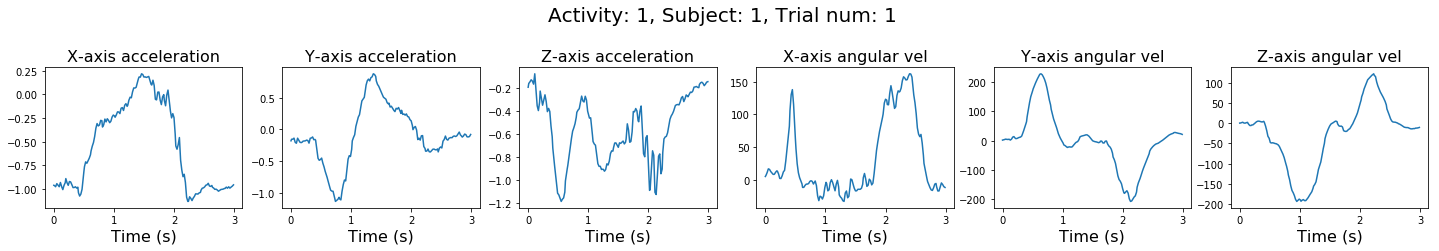

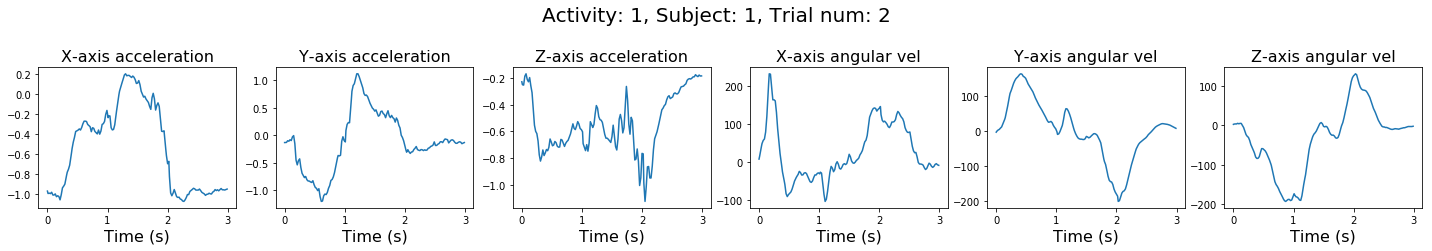

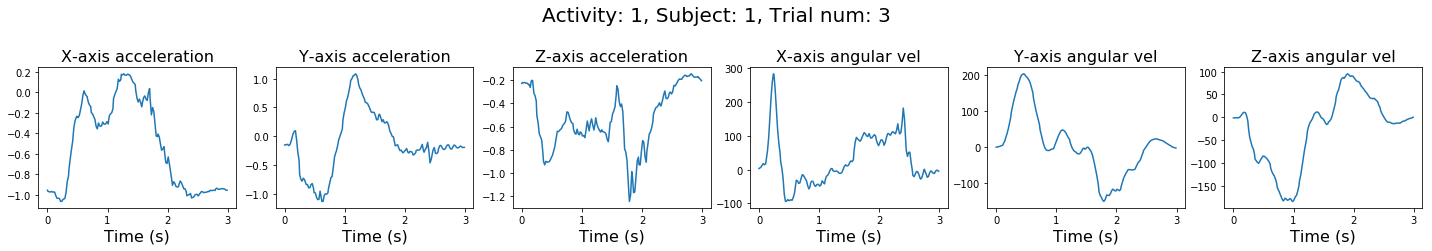

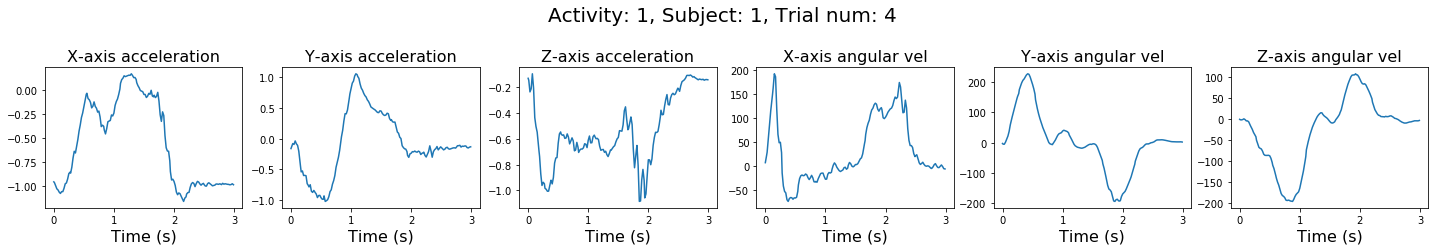

In [8]:
for trial in range(0,trial_end):
    generate_plot(x_axis_data,activity_data, 0, 0, trial)

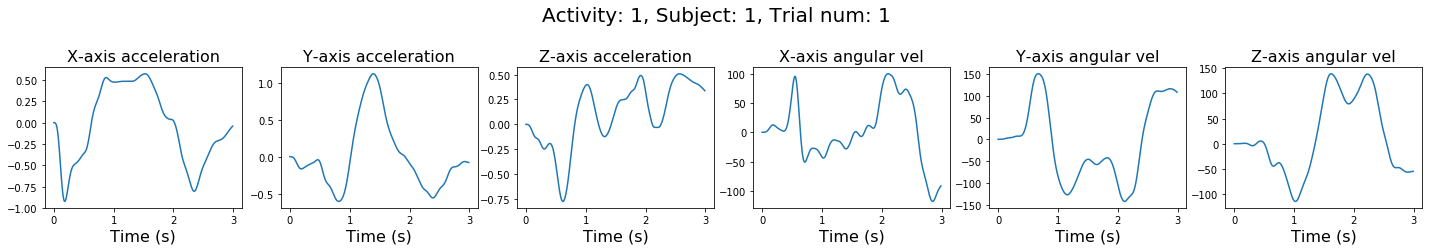

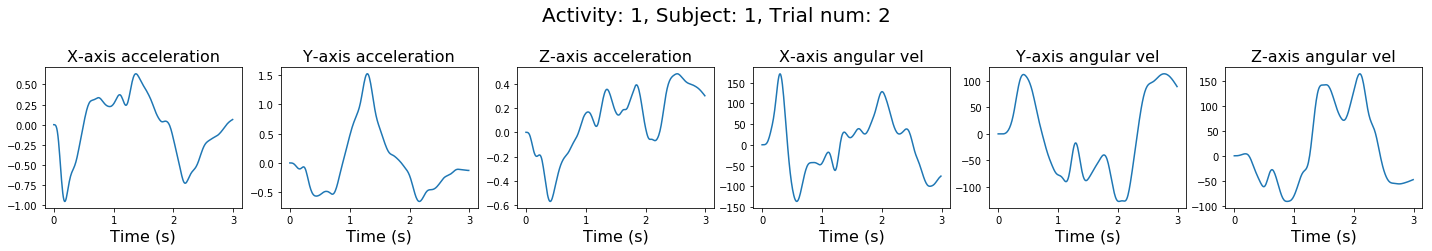

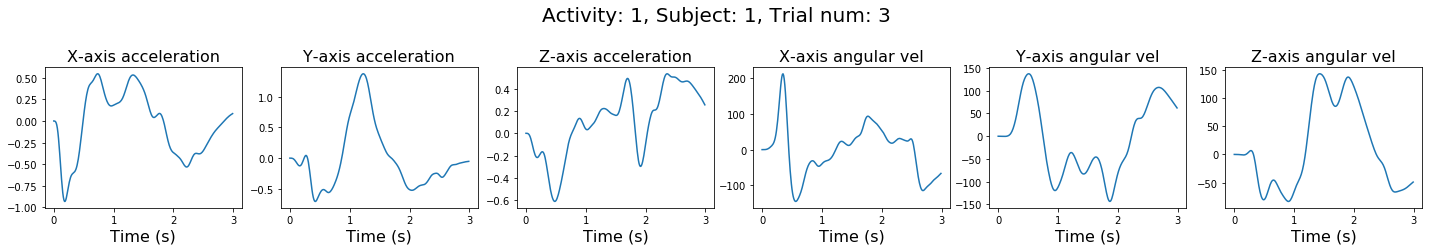

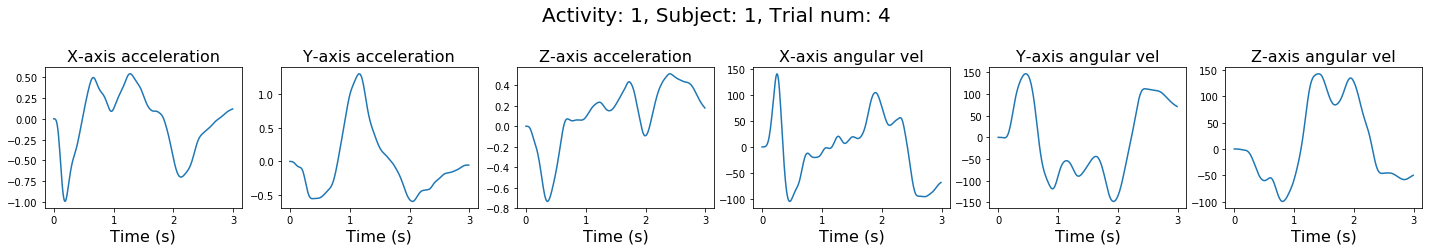

In [10]:
for trial in range(0,trial_end):
    generate_plot(x_axis_data,bp_activity_data, 0, 0, trial)    

## Compare variation of graph for different subjects, Activty 1, Trial 1

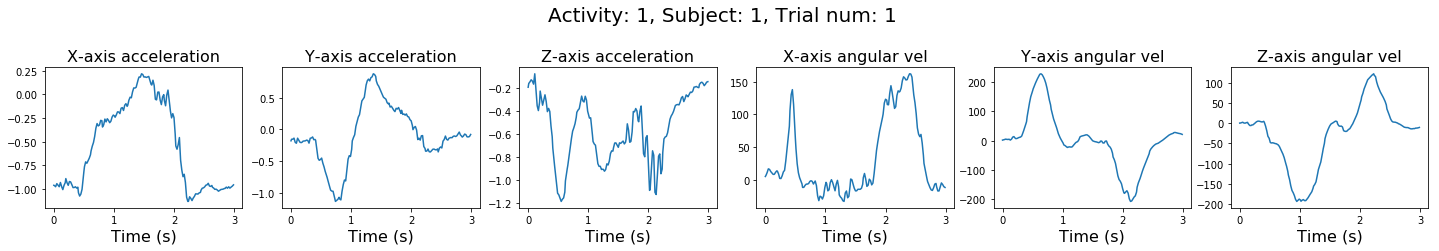

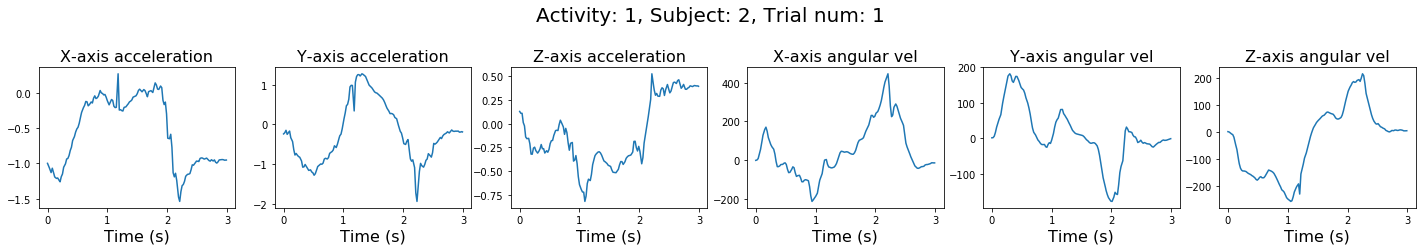

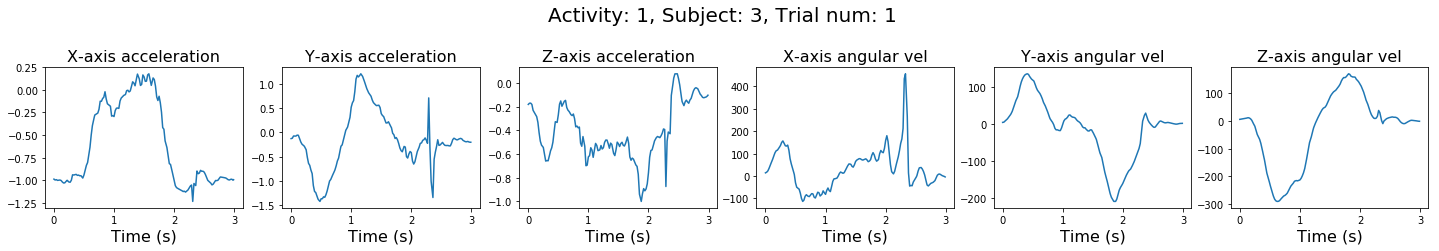

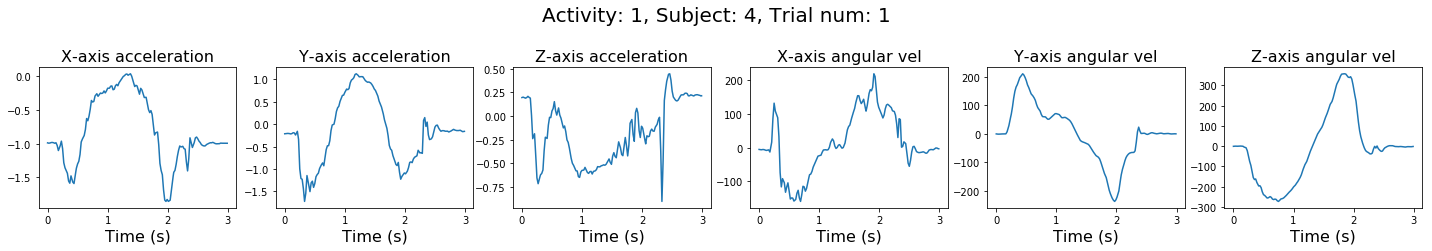

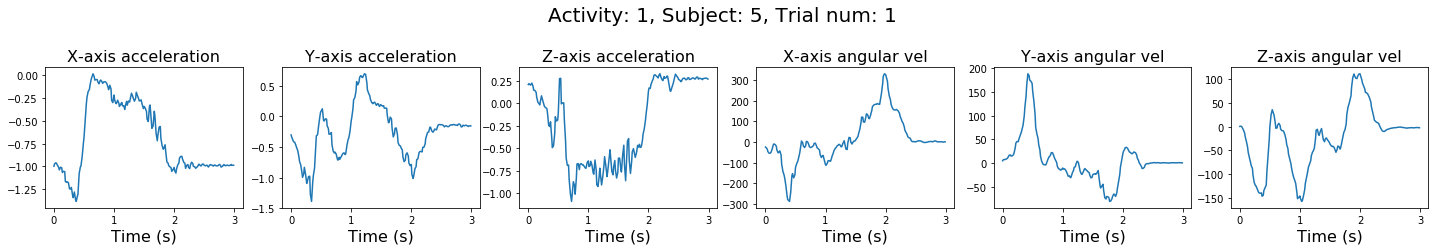

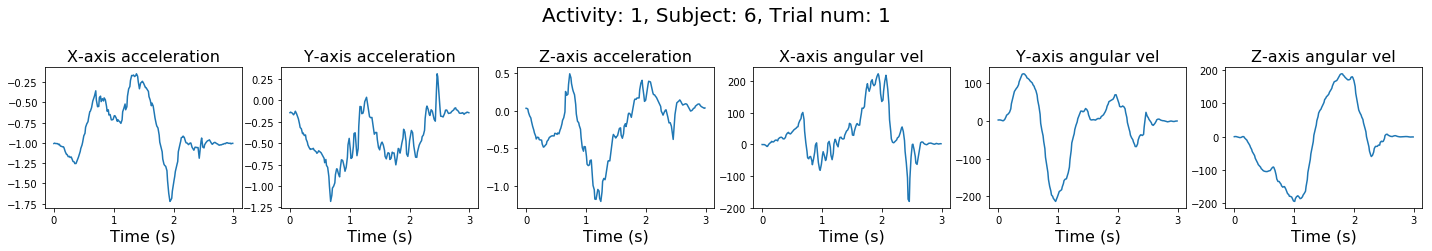

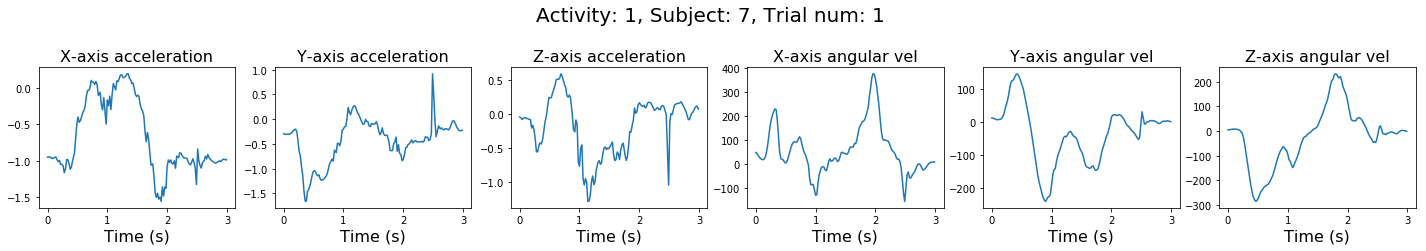

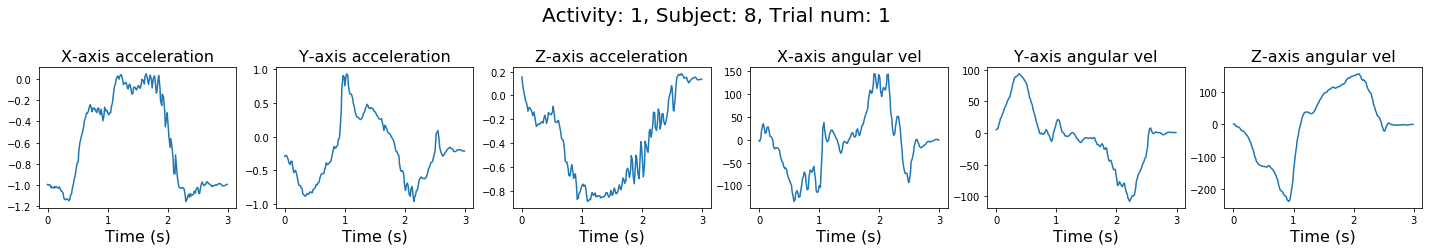

In [11]:
for s in range(0,subject_end):
    generate_plot(x_axis_data,activity_data, 0, s, 0)

## Compare different activities performed by same Subject, in trial 1

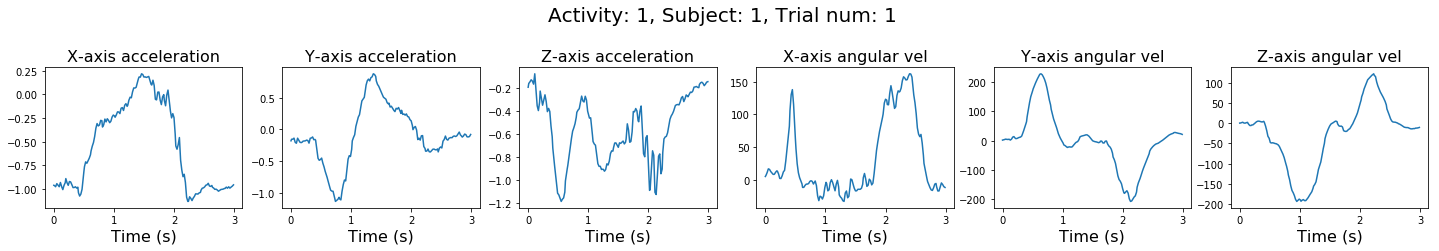

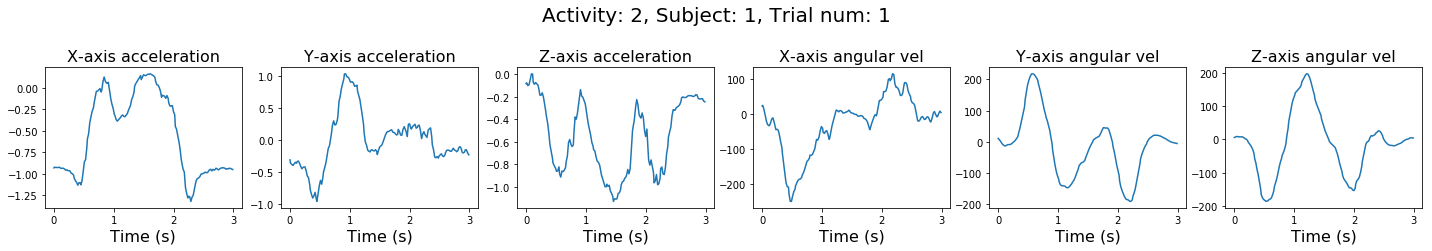

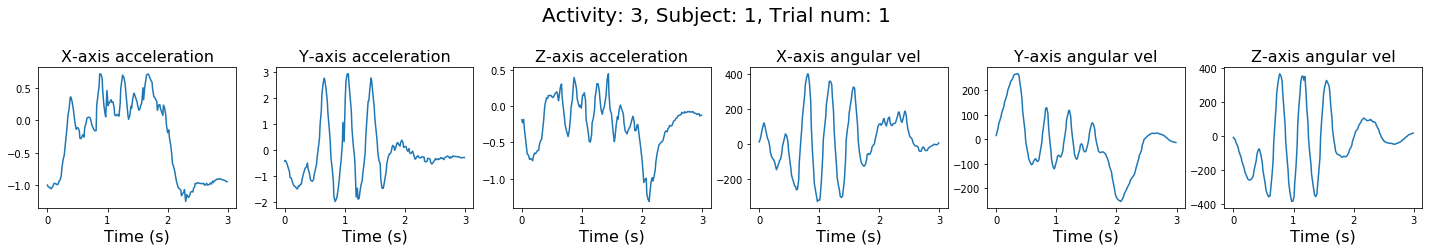

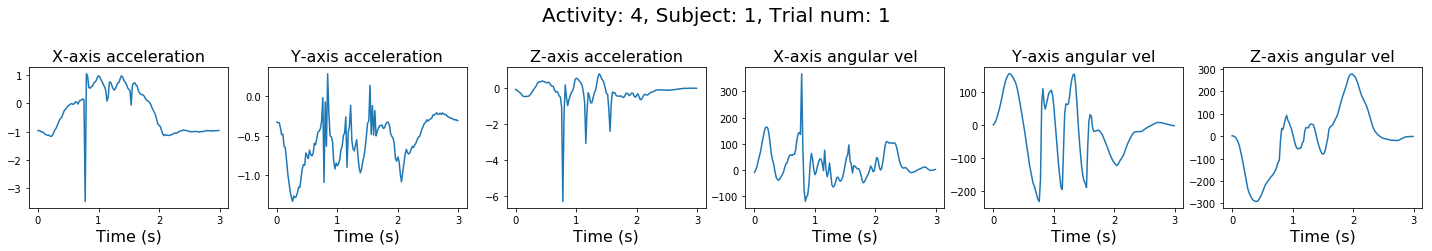

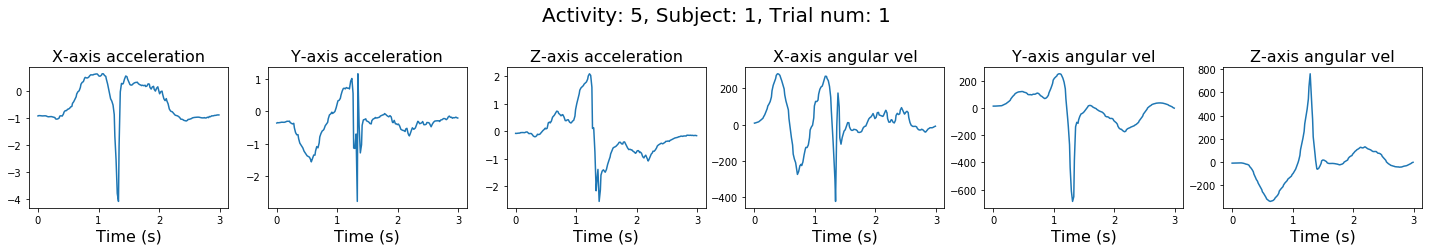

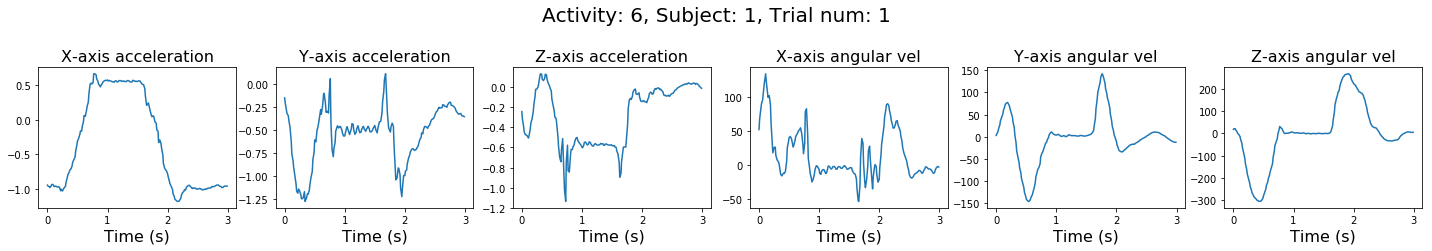

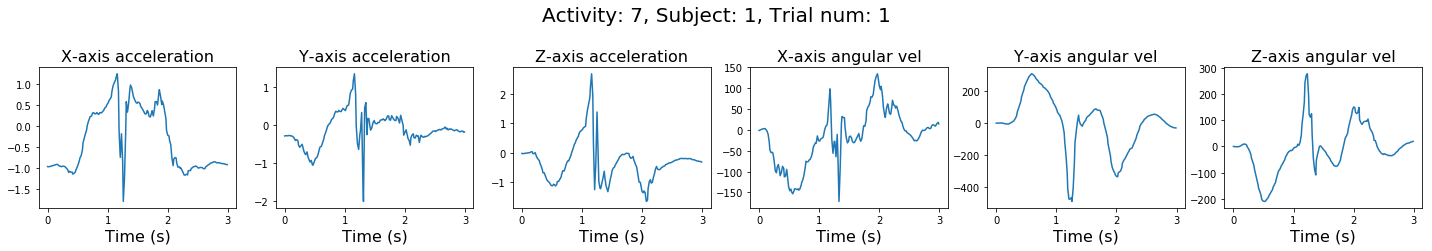

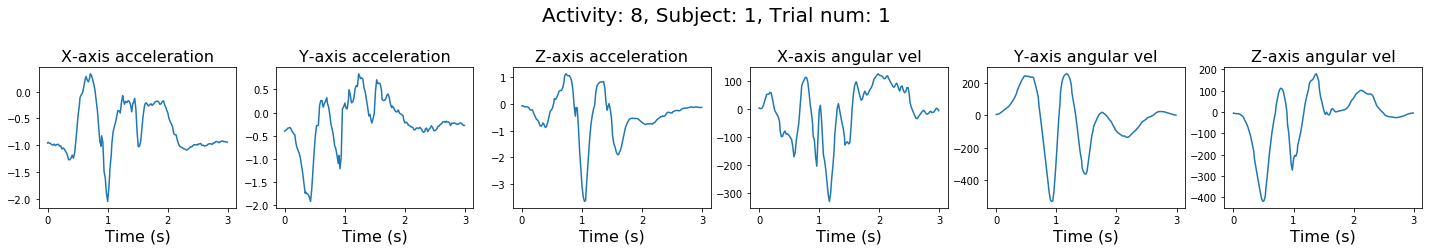

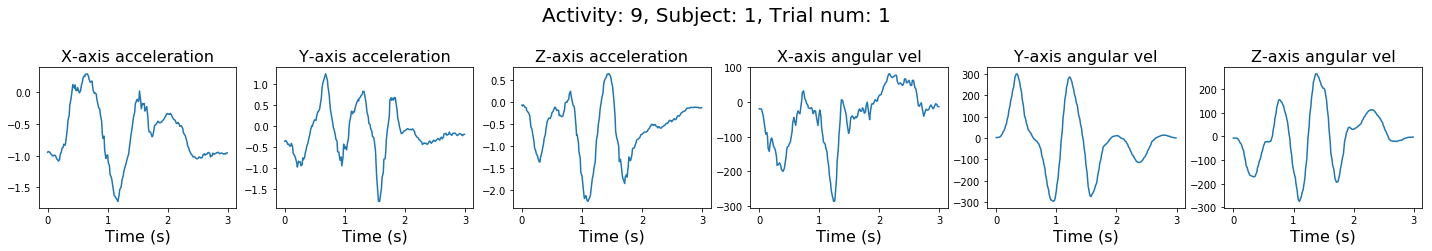

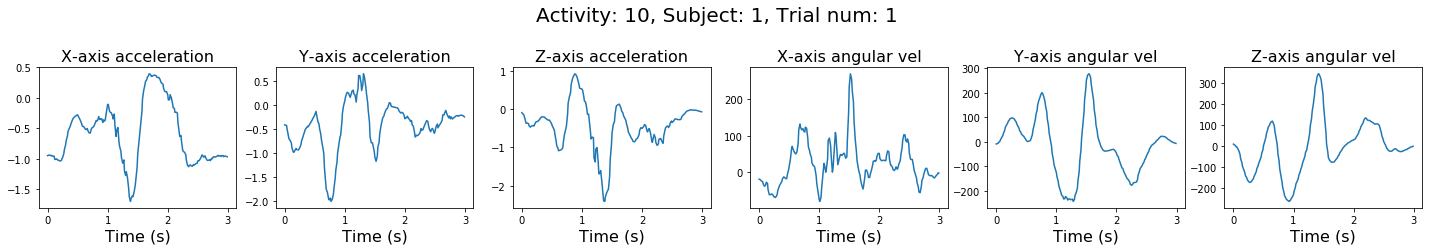

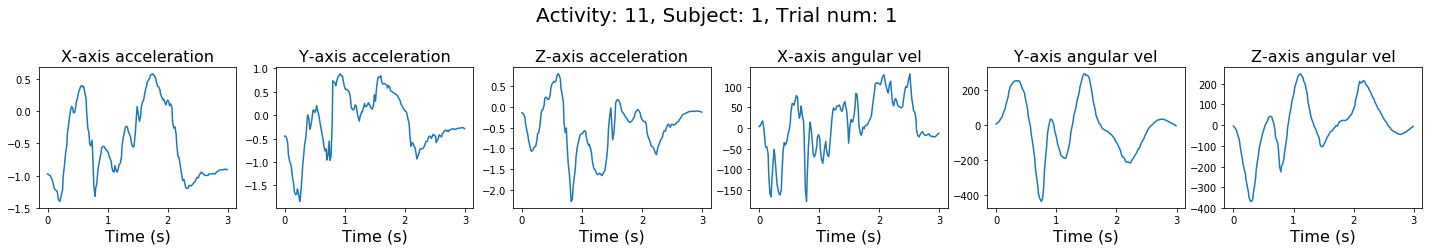

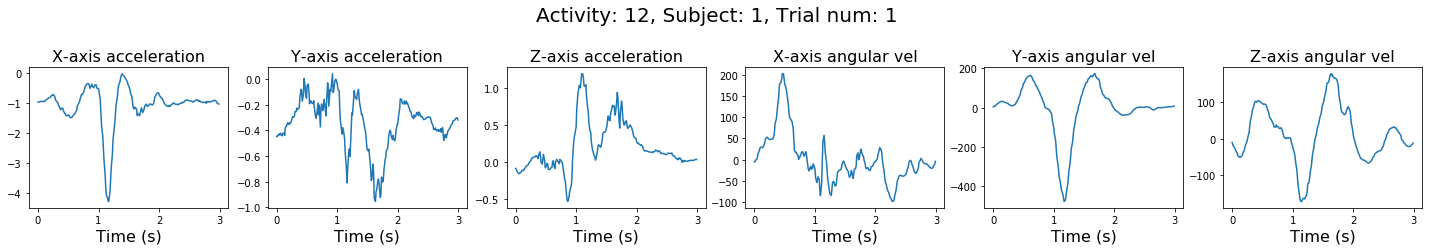

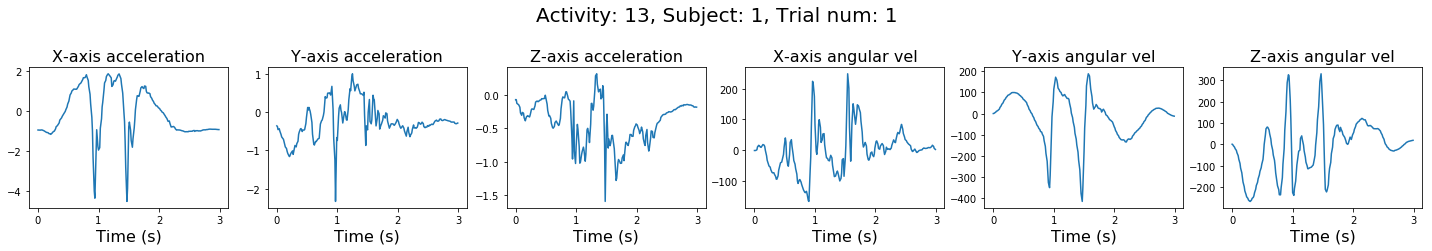

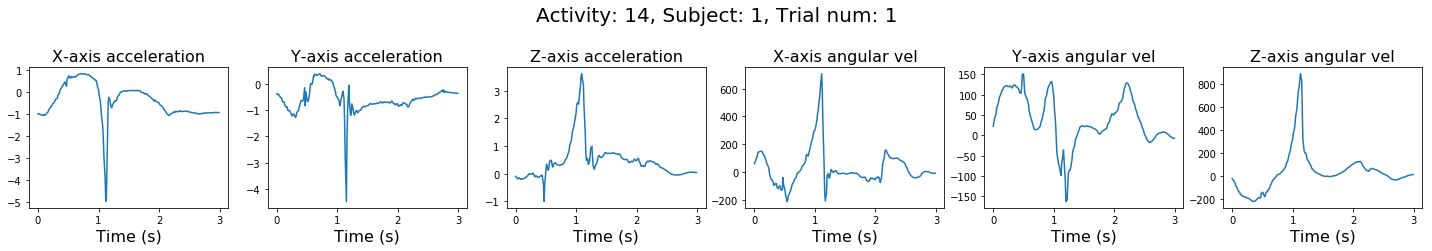

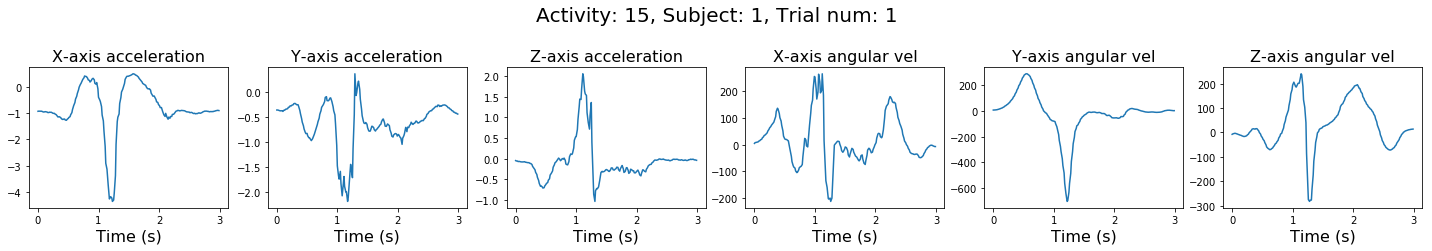

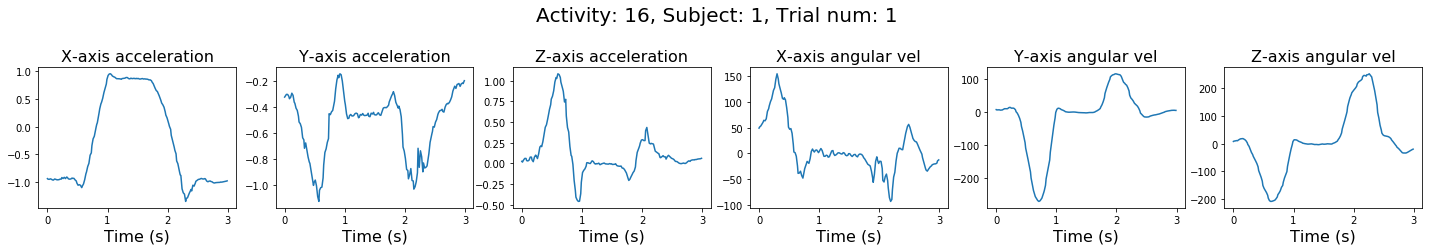

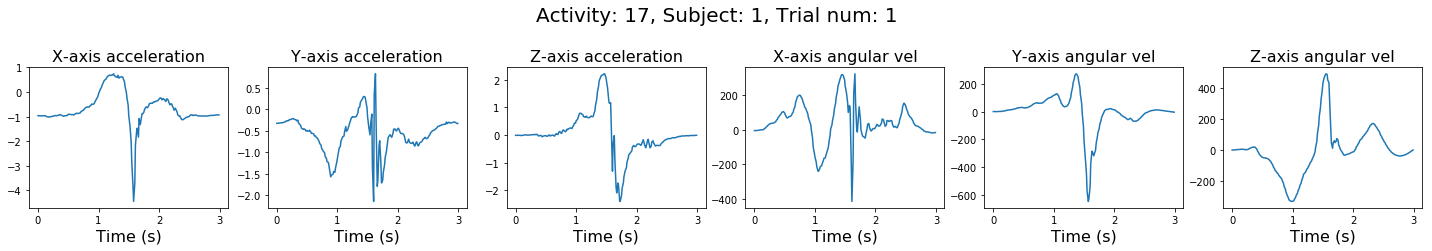

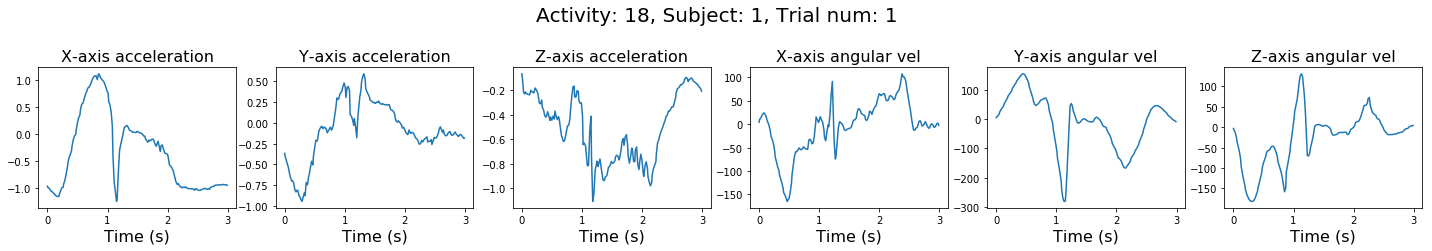

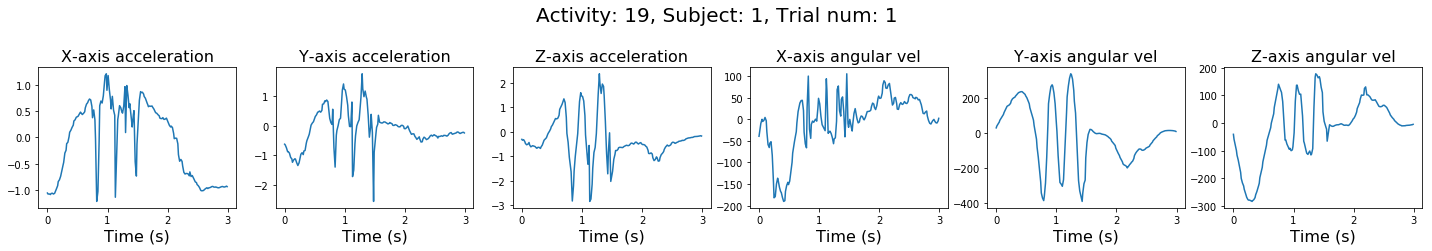

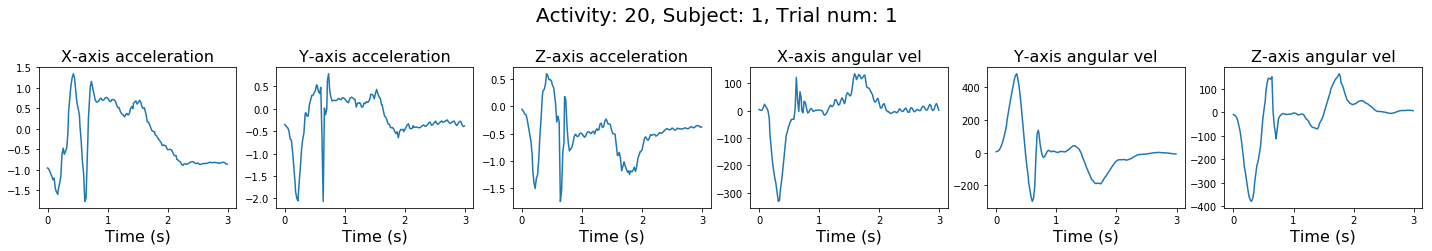

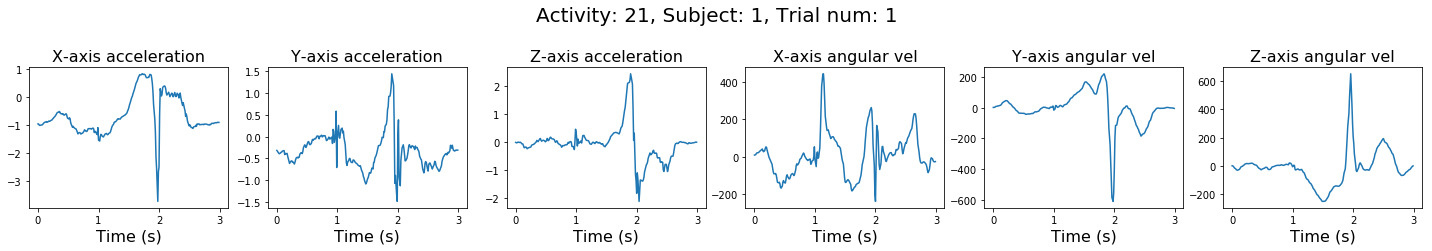

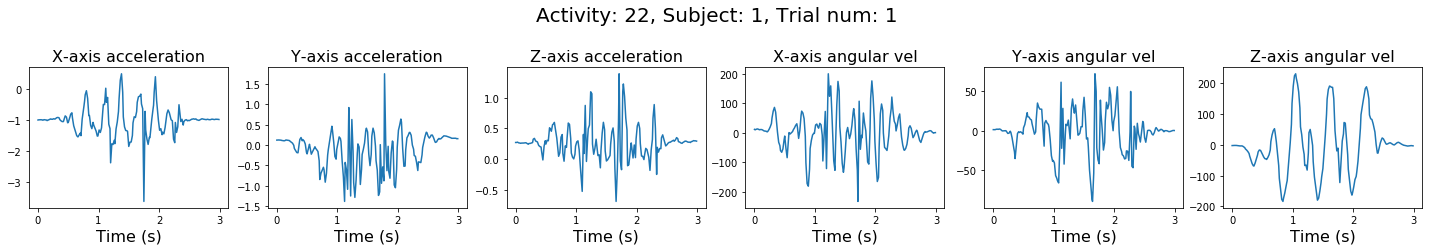

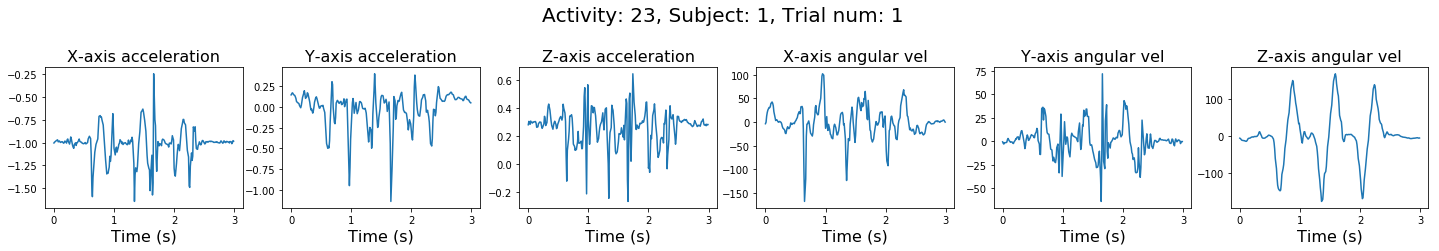

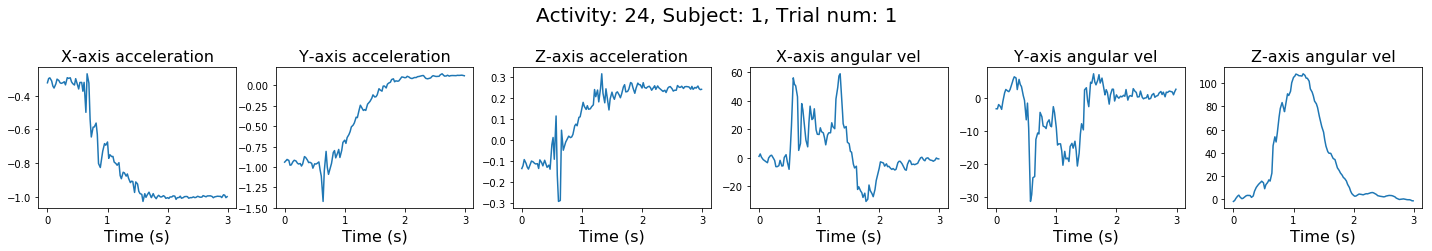

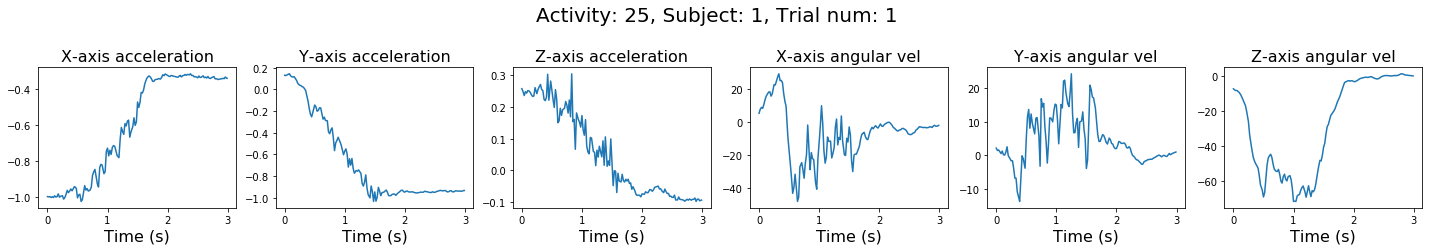

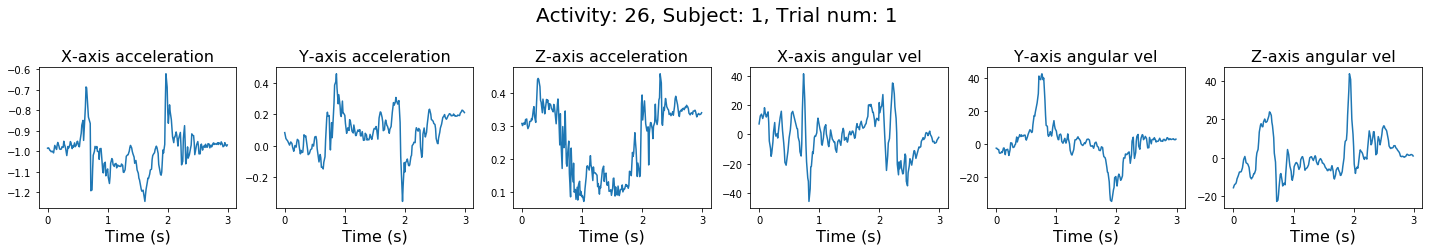

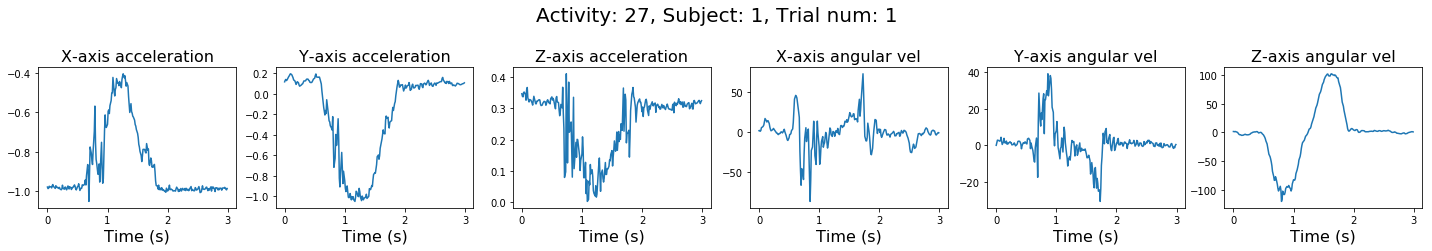

In [12]:
for a in range(0,activity_end):
    generate_plot(x_axis_data,activity_data, a, 0, 0)

## Classification of activity using graph waveforms

In [13]:
from sklearn.preprocessing import MinMaxScaler

def fit_transform_data_for_neural_network(activity_array):
    nn_data =[]
    nn_output = []

    trial_end = 4
    activity_end = 27
    subject_end = 8

    for activity in range(0,activity_end):
        for person in range(0,subject_end):  
            for trial in range(0,trial_end):
                temp_data = np.array(activity_array[activity][person][trial])
                temp_data_t = temp_data.T
                scaler = MinMaxScaler(feature_range=(-1, 1))
                temp_data_t_s = scaler.fit_transform(temp_data_t)
                nn_data.append(temp_data_t_s)
                nn_output.append(activity)

    nn_features = np.array(nn_data)
    return nn_features,nn_output 

In [14]:
X, Y = fit_transform_data_for_neural_network(activity_data)
Xbp, Ybp = fit_transform_data_for_neural_network(bp_activity_data)

In [24]:
from sklearn.model_selection import train_test_split
Xr_train, Xr_test, yr_train, yr_test = train_test_split(X, Y, test_size=0.3, random_state =1)
Xrb_train, Xrb_test, yrb_train, yrb_test = train_test_split(Xbp, Ybp, test_size=0.3, random_state =1)

### LSTM

C:\Users\Beer\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


Train on 604 samples, validate on 260 samples
Epoch 1/500
604/604 [==============================] - 18s 29ms/step - loss: 3.2664 - acc: 0.0861 - val_loss: 3.2175 - val_acc: 0.1231
Epoch 2/500
604/604 [==============================] - 15s 25ms/step - loss: 3.0953 - acc: 0.1391 - val_loss: 2.9871 - val_acc: 0.1077
Epoch 3/500
604/604 [==============================] - 15s 24ms/step - loss: 2.9620 - acc: 0.0993 - val_loss: 2.9442 - val_acc: 0.1038
Epoch 4/500
604/604 [==============================] - 15s 25ms/step - loss: 2.9502 - acc: 0.0993 - val_loss: 2.9012 - val_acc: 0.0808
Epoch 5/500
604/604 [==============================] - 15s 24ms/step - loss: 2.8426 - acc: 0.1258 - val_loss: 2.8421 - val_acc: 0.1462
Epoch 6/500
604/604 [==============================] - 15s 25ms/step - loss: 2.7861 - acc: 0.1871 - val_loss: 2.7939 - val_acc: 0.1577
Epoch 7/500
604/604 [==============================] - 15s 24ms/step - loss: 2.7497 - acc: 0.1871 - val_loss: 2.7883 - val_acc: 0.1385
Epoch 8/5

Epoch 61/500
604/604 [==============================] - 14s 24ms/step - loss: 1.6126 - acc: 0.4354 - val_loss: 1.7623 - val_acc: 0.4462
Epoch 62/500
604/604 [==============================] - 14s 24ms/step - loss: 1.5479 - acc: 0.4454 - val_loss: 1.7071 - val_acc: 0.3923
Epoch 63/500
604/604 [==============================] - 15s 24ms/step - loss: 1.5050 - acc: 0.4586 - val_loss: 1.7464 - val_acc: 0.3923
Epoch 64/500
604/604 [==============================] - 15s 25ms/step - loss: 1.5069 - acc: 0.4553 - val_loss: 1.6734 - val_acc: 0.3962
Epoch 65/500
604/604 [==============================] - 15s 25ms/step - loss: 1.5625 - acc: 0.4421 - val_loss: 1.7881 - val_acc: 0.4077
Epoch 66/500
604/604 [==============================] - 14s 24ms/step - loss: 1.5860 - acc: 0.4884 - val_loss: 1.7639 - val_acc: 0.4077
Epoch 67/500
604/604 [==============================] - 15s 24ms/step - loss: 1.5058 - acc: 0.4851 - val_loss: 1.6809 - val_acc: 0.3846
Epoch 68/500
604/604 [==========================

604/604 [==============================] - 14s 24ms/step - loss: 0.9921 - acc: 0.6755 - val_loss: 1.4786 - val_acc: 0.5423
Epoch 122/500
604/604 [==============================] - 14s 24ms/step - loss: 0.9892 - acc: 0.6672 - val_loss: 1.4655 - val_acc: 0.5346
Epoch 123/500
604/604 [==============================] - 14s 24ms/step - loss: 0.9449 - acc: 0.6755 - val_loss: 1.4626 - val_acc: 0.5423
Epoch 124/500
604/604 [==============================] - 14s 24ms/step - loss: 1.0380 - acc: 0.6474 - val_loss: 1.5316 - val_acc: 0.4769
Epoch 125/500
604/604 [==============================] - 14s 23ms/step - loss: 1.0181 - acc: 0.6589 - val_loss: 1.4563 - val_acc: 0.5308
Epoch 126/500
604/604 [==============================] - 14s 23ms/step - loss: 0.9156 - acc: 0.6987 - val_loss: 1.4488 - val_acc: 0.5115
Epoch 127/500
604/604 [==============================] - 14s 23ms/step - loss: 0.8613 - acc: 0.7185 - val_loss: 1.4051 - val_acc: 0.5731
Epoch 128/500
604/604 [==============================] 

Epoch 181/500
604/604 [==============================] - 14s 24ms/step - loss: 0.7080 - acc: 0.7748 - val_loss: 1.6460 - val_acc: 0.4923
Epoch 182/500
604/604 [==============================] - 14s 24ms/step - loss: 0.8396 - acc: 0.7036 - val_loss: 1.4757 - val_acc: 0.5538
Epoch 183/500
604/604 [==============================] - 14s 24ms/step - loss: 0.7113 - acc: 0.7682 - val_loss: 1.3866 - val_acc: 0.5577
Epoch 184/500
604/604 [==============================] - 14s 24ms/step - loss: 0.6531 - acc: 0.7848 - val_loss: 1.4873 - val_acc: 0.5577
Epoch 185/500
604/604 [==============================] - 15s 24ms/step - loss: 0.5420 - acc: 0.8361 - val_loss: 1.4048 - val_acc: 0.5846
Epoch 186/500
604/604 [==============================] - 15s 25ms/step - loss: 0.4733 - acc: 0.8593 - val_loss: 1.3840 - val_acc: 0.5923
Epoch 187/500
604/604 [==============================] - 15s 25ms/step - loss: 0.4744 - acc: 0.8543 - val_loss: 1.3649 - val_acc: 0.6192
Epoch 188/500
604/604 [==================

Epoch 241/500
604/604 [==============================] - 14s 24ms/step - loss: 0.2527 - acc: 0.9421 - val_loss: 1.4235 - val_acc: 0.5962
Epoch 242/500
604/604 [==============================] - 14s 24ms/step - loss: 0.2517 - acc: 0.9470 - val_loss: 1.4944 - val_acc: 0.5654
Epoch 243/500
604/604 [==============================] - 15s 25ms/step - loss: 0.2250 - acc: 0.9570 - val_loss: 1.4737 - val_acc: 0.5846
Epoch 244/500
604/604 [==============================] - 15s 24ms/step - loss: 0.2273 - acc: 0.9487 - val_loss: 1.5007 - val_acc: 0.5692
Epoch 245/500
604/604 [==============================] - 14s 24ms/step - loss: 0.2212 - acc: 0.9503 - val_loss: 1.5465 - val_acc: 0.6038
Epoch 246/500
604/604 [==============================] - 14s 24ms/step - loss: 0.2098 - acc: 0.9570 - val_loss: 1.4977 - val_acc: 0.5923
Epoch 247/500
604/604 [==============================] - 14s 24ms/step - loss: 0.1743 - acc: 0.9768 - val_loss: 1.6068 - val_acc: 0.5538
Epoch 248/500
604/604 [==================

Epoch 301/500
604/604 [==============================] - 15s 25ms/step - loss: 0.2079 - acc: 0.9470 - val_loss: 1.4604 - val_acc: 0.5846
Epoch 302/500
604/604 [==============================] - 15s 25ms/step - loss: 0.1840 - acc: 0.9520 - val_loss: 1.4965 - val_acc: 0.6269
Epoch 303/500
604/604 [==============================] - 15s 25ms/step - loss: 0.1565 - acc: 0.9636 - val_loss: 1.4951 - val_acc: 0.6308
Epoch 304/500
604/604 [==============================] - 16s 26ms/step - loss: 0.1346 - acc: 0.9685 - val_loss: 1.5315 - val_acc: 0.6154
Epoch 305/500
604/604 [==============================] - 15s 24ms/step - loss: 0.1261 - acc: 0.9719 - val_loss: 1.5350 - val_acc: 0.6346
Epoch 306/500
604/604 [==============================] - 14s 24ms/step - loss: 0.1149 - acc: 0.9735 - val_loss: 1.5562 - val_acc: 0.6346
Epoch 307/500
604/604 [==============================] - 15s 24ms/step - loss: 0.1025 - acc: 0.9818 - val_loss: 1.5929 - val_acc: 0.6269
Epoch 308/500
604/604 [==================

Epoch 361/500
604/604 [==============================] - 15s 24ms/step - loss: 0.3613 - acc: 0.9089 - val_loss: 1.5305 - val_acc: 0.6038
Epoch 362/500
604/604 [==============================] - 15s 24ms/step - loss: 0.3955 - acc: 0.9056 - val_loss: 1.6134 - val_acc: 0.5615
Epoch 363/500
604/604 [==============================] - 15s 24ms/step - loss: 0.6921 - acc: 0.7864 - val_loss: 1.6951 - val_acc: 0.5692
Epoch 364/500
604/604 [==============================] - 15s 24ms/step - loss: 0.9029 - acc: 0.7301 - val_loss: 1.6814 - val_acc: 0.5577
Epoch 365/500
604/604 [==============================] - 14s 24ms/step - loss: 0.7116 - acc: 0.7533 - val_loss: 1.6151 - val_acc: 0.5692
Epoch 366/500
604/604 [==============================] - 15s 24ms/step - loss: 0.5491 - acc: 0.8295 - val_loss: 1.5689 - val_acc: 0.5769
Epoch 367/500
604/604 [==============================] - 14s 24ms/step - loss: 0.4895 - acc: 0.8593 - val_loss: 1.5540 - val_acc: 0.5846
Epoch 368/500
604/604 [==================

Epoch 421/500
604/604 [==============================] - 15s 24ms/step - loss: 0.2395 - acc: 0.9404 - val_loss: 1.4887 - val_acc: 0.6346
Epoch 422/500
604/604 [==============================] - 15s 24ms/step - loss: 0.3782 - acc: 0.8825 - val_loss: 1.5698 - val_acc: 0.5962
Epoch 423/500
604/604 [==============================] - 14s 24ms/step - loss: 0.4060 - acc: 0.8775 - val_loss: 1.5728 - val_acc: 0.6077
Epoch 424/500
604/604 [==============================] - 15s 24ms/step - loss: 0.2698 - acc: 0.9172 - val_loss: 1.5181 - val_acc: 0.6269
Epoch 425/500
604/604 [==============================] - 15s 24ms/step - loss: 0.2389 - acc: 0.9338 - val_loss: 1.5403 - val_acc: 0.6192
Epoch 426/500
604/604 [==============================] - 14s 24ms/step - loss: 0.1980 - acc: 0.9487 - val_loss: 1.5234 - val_acc: 0.6077
Epoch 427/500
604/604 [==============================] - 14s 24ms/step - loss: 0.1684 - acc: 0.9636 - val_loss: 1.5480 - val_acc: 0.6000
Epoch 428/500
604/604 [==================

Epoch 481/500
604/604 [==============================] - 15s 24ms/step - loss: 0.0188 - acc: 0.9983 - val_loss: 1.7171 - val_acc: 0.6538
Epoch 482/500
604/604 [==============================] - 15s 25ms/step - loss: 0.0191 - acc: 0.9967 - val_loss: 1.7121 - val_acc: 0.6538
Epoch 483/500
604/604 [==============================] - 15s 25ms/step - loss: 0.0177 - acc: 0.9983 - val_loss: 1.7166 - val_acc: 0.6500
Epoch 484/500
604/604 [==============================] - 15s 24ms/step - loss: 0.0170 - acc: 0.9983 - val_loss: 1.7345 - val_acc: 0.6538
Epoch 485/500
604/604 [==============================] - 16s 26ms/step - loss: 0.0172 - acc: 0.9983 - val_loss: 1.7437 - val_acc: 0.6462
Epoch 486/500
604/604 [==============================] - 16s 26ms/step - loss: 0.0162 - acc: 0.9983 - val_loss: 1.7480 - val_acc: 0.6385
Epoch 487/500
604/604 [==============================] - 15s 24ms/step - loss: 0.0156 - acc: 0.9983 - val_loss: 1.7575 - val_acc: 0.6385
Epoch 488/500
604/604 [==================

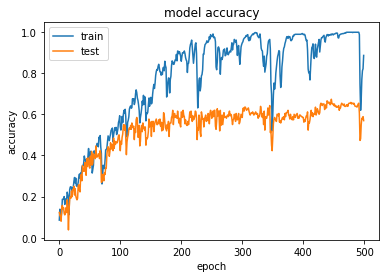

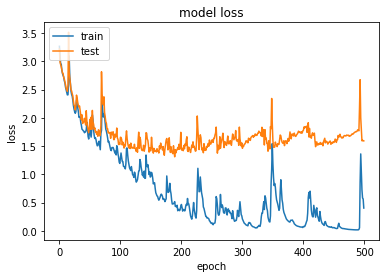

Accuracy: 56.92%


In [16]:
from keras.utils import to_categorical
from keras.layers.recurrent import GRU
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import LSTM
from keras.models import Sequential
from keras.layers import Dense
import keras.optimizers as optimizers

yr_train_binary = to_categorical(yr_train)
yr_test_binary = to_categorical(yr_test)


model = Sequential()
model.add(LSTM(100, input_shape=(300, 6)))
model.add(Dense(27,activation='sigmoid'))
adam = optimizers.Adam(lr=0.1, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

historyL  = model.fit(Xr_train, yr_train_binary, validation_data=(Xr_test,yr_test_binary), epochs=500)
scoresL = model.evaluate(Xr_test, yr_test_binary, verbose=0)
print(historyL.history.keys())
# summarize history for accuracy
plt.plot(historyL.history['acc'])
plt.plot(historyL.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(historyL.history['loss'])
plt.plot(historyL.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


print("Accuracy: %.2f%%" % (scoresL[1]*100))

In [17]:
from sklearn.metrics import confusion_matrix, classification_report

predictionsLSTM = model.predict(Xr_test)
target_names = ['Swipe Left', 'Swipe Right', 'Wave', 'Clap', 'Throw', 'Arm Cross', 'Basketball Shoot', 
                'Draw X', 'Draw Circle (CW)', 'Draw Circle (CCW)', 'Draw Triangle', 'Bowling', 'Boxing', 
                'Baseball Swing', 'Tennis Swing', 'Arm Curl', 'Tennis Serve', 'Push', 'Knock', 'Catch',
                'Pickup and Throw', 'Jog', 'Walk', 'Sit to Stand', 'Stand to Sit', 'Lunge', 'Squat']
print(classification_report(yr_test,  predictionsLSTM.argmax(axis=1), target_names=target_names))

                   precision    recall  f1-score   support

       Swipe Left       0.55      0.75      0.63         8
      Swipe Right       0.90      0.82      0.86        11
             Wave       0.69      0.75      0.72        12
             Clap       0.62      0.67      0.64        12
            Throw       0.33      0.33      0.33         6
        Arm Cross       0.62      0.62      0.62         8
 Basketball Shoot       0.57      0.44      0.50         9
           Draw X       0.80      0.33      0.47        12
 Draw Circle (CW)       0.42      0.62      0.50         8
Draw Circle (CCW)       0.33      0.30      0.32        10
    Draw Triangle       0.22      0.25      0.24         8
          Bowling       0.75      0.67      0.71         9
           Boxing       0.11      0.12      0.12         8
   Baseball Swing       0.73      0.73      0.73        11
     Tennis Swing       0.33      0.60      0.43         5
         Arm Curl       0.83      0.77      0.80       

Confusion matrix


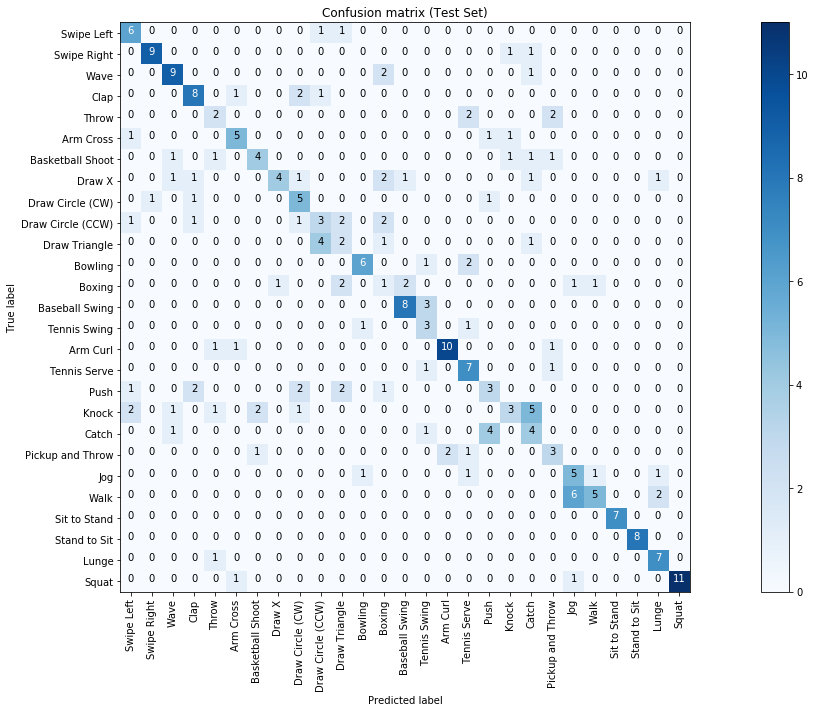

In [18]:
from utils import plot_confusion_matrix

cnf_matrix = confusion_matrix(yr_test, predictionsLSTM.argmax(axis=1))
np.set_printoptions(precision=2)
plt.figure(figsize=(20,10))
plot_confusion_matrix(cnf_matrix, classes=target_names,
                      title='Confusion matrix (Test Set)')

Train on 604 samples, validate on 260 samples
Epoch 1/500
604/604 [==============================] - 16s 27ms/step - loss: 3.2719 - acc: 0.0911 - val_loss: 3.2216 - val_acc: 0.1346
Epoch 2/500
604/604 [==============================] - 15s 25ms/step - loss: 3.0989 - acc: 0.1175 - val_loss: 3.0157 - val_acc: 0.1077
Epoch 3/500
604/604 [==============================] - 14s 24ms/step - loss: 2.9706 - acc: 0.1242 - val_loss: 2.9287 - val_acc: 0.0808
Epoch 4/500
604/604 [==============================] - 14s 23ms/step - loss: 2.9123 - acc: 0.0927 - val_loss: 2.9530 - val_acc: 0.1038
Epoch 5/500
604/604 [==============================] - 14s 23ms/step - loss: 2.8695 - acc: 0.0927 - val_loss: 2.8780 - val_acc: 0.0769
Epoch 6/500
604/604 [==============================] - 14s 23ms/step - loss: 2.8407 - acc: 0.0911 - val_loss: 2.8457 - val_acc: 0.0846
Epoch 7/500
604/604 [==============================] - 15s 24ms/step - loss: 2.8064 - acc: 0.1060 - val_loss: 2.7786 - val_acc: 0.1000
Epoch 8/5

Epoch 61/500
604/604 [==============================] - 14s 24ms/step - loss: 2.3970 - acc: 0.2848 - val_loss: 2.7251 - val_acc: 0.1654
Epoch 62/500
604/604 [==============================] - 14s 24ms/step - loss: 2.2976 - acc: 0.2732 - val_loss: 2.2404 - val_acc: 0.2885
Epoch 63/500
604/604 [==============================] - 15s 24ms/step - loss: 2.0333 - acc: 0.3444 - val_loss: 2.1160 - val_acc: 0.2923
Epoch 64/500
604/604 [==============================] - 14s 24ms/step - loss: 2.0483 - acc: 0.3742 - val_loss: 2.1497 - val_acc: 0.3077
Epoch 65/500
604/604 [==============================] - 14s 24ms/step - loss: 1.9187 - acc: 0.4338 - val_loss: 1.9765 - val_acc: 0.3923
Epoch 66/500
604/604 [==============================] - 14s 23ms/step - loss: 2.1391 - acc: 0.3758 - val_loss: 2.1401 - val_acc: 0.3192
Epoch 67/500
604/604 [==============================] - 15s 24ms/step - loss: 1.9906 - acc: 0.3775 - val_loss: 2.1966 - val_acc: 0.3231
Epoch 68/500
604/604 [==========================

604/604 [==============================] - 14s 23ms/step - loss: 1.0404 - acc: 0.6805 - val_loss: 1.3910 - val_acc: 0.5923
Epoch 122/500
604/604 [==============================] - 14s 24ms/step - loss: 1.0881 - acc: 0.6722 - val_loss: 1.3549 - val_acc: 0.6269
Epoch 123/500
604/604 [==============================] - 14s 24ms/step - loss: 1.5721 - acc: 0.4818 - val_loss: 1.9004 - val_acc: 0.4115
Epoch 124/500
604/604 [==============================] - 14s 24ms/step - loss: 1.4467 - acc: 0.5265 - val_loss: 1.5092 - val_acc: 0.5308
Epoch 125/500
604/604 [==============================] - 14s 24ms/step - loss: 1.2712 - acc: 0.6142 - val_loss: 1.4806 - val_acc: 0.5000
Epoch 126/500
604/604 [==============================] - 14s 23ms/step - loss: 1.2693 - acc: 0.5977 - val_loss: 1.4680 - val_acc: 0.5077
Epoch 127/500
604/604 [==============================] - 14s 23ms/step - loss: 1.1125 - acc: 0.6407 - val_loss: 1.4081 - val_acc: 0.5500
Epoch 128/500
604/604 [==============================] 

Epoch 181/500
604/604 [==============================] - 16s 26ms/step - loss: 0.8659 - acc: 0.7632 - val_loss: 1.2261 - val_acc: 0.6269
Epoch 182/500
604/604 [==============================] - 16s 27ms/step - loss: 0.8568 - acc: 0.7450 - val_loss: 1.2708 - val_acc: 0.6231
Epoch 183/500
604/604 [==============================] - 16s 26ms/step - loss: 0.8656 - acc: 0.7599 - val_loss: 1.1982 - val_acc: 0.6269
Epoch 184/500
604/604 [==============================] - 18s 29ms/step - loss: 0.8268 - acc: 0.7666 - val_loss: 1.2499 - val_acc: 0.6154
Epoch 185/500
604/604 [==============================] - 17s 29ms/step - loss: 0.8986 - acc: 0.7318 - val_loss: 1.2102 - val_acc: 0.6269
Epoch 186/500
604/604 [==============================] - 17s 29ms/step - loss: 0.9595 - acc: 0.7036 - val_loss: 1.3471 - val_acc: 0.5808
Epoch 187/500
604/604 [==============================] - 17s 29ms/step - loss: 1.0678 - acc: 0.6623 - val_loss: 1.2922 - val_acc: 0.5731
Epoch 188/500
604/604 [==================

Epoch 241/500
604/604 [==============================] - 17s 28ms/step - loss: 0.5086 - acc: 0.8642 - val_loss: 1.0097 - val_acc: 0.6692
Epoch 242/500
604/604 [==============================] - 17s 28ms/step - loss: 0.4445 - acc: 0.8858 - val_loss: 0.9887 - val_acc: 0.6731
Epoch 243/500
604/604 [==============================] - 17s 28ms/step - loss: 0.6386 - acc: 0.7914 - val_loss: 1.0798 - val_acc: 0.6808
Epoch 244/500
604/604 [==============================] - 17s 28ms/step - loss: 1.0156 - acc: 0.6722 - val_loss: 1.8022 - val_acc: 0.4385
Epoch 245/500
604/604 [==============================] - 17s 28ms/step - loss: 1.3702 - acc: 0.5596 - val_loss: 1.4451 - val_acc: 0.5577
Epoch 246/500
604/604 [==============================] - 17s 29ms/step - loss: 1.0484 - acc: 0.6623 - val_loss: 1.2134 - val_acc: 0.6231
Epoch 247/500
604/604 [==============================] - 17s 28ms/step - loss: 0.9273 - acc: 0.7003 - val_loss: 1.3254 - val_acc: 0.5654
Epoch 248/500
604/604 [==================

Epoch 301/500
604/604 [==============================] - 17s 28ms/step - loss: 0.1916 - acc: 0.9669 - val_loss: 0.8444 - val_acc: 0.7269
Epoch 302/500
604/604 [==============================] - 17s 28ms/step - loss: 0.1606 - acc: 0.9752 - val_loss: 0.8194 - val_acc: 0.7577
Epoch 303/500
604/604 [==============================] - 17s 27ms/step - loss: 0.1421 - acc: 0.9834 - val_loss: 0.7987 - val_acc: 0.7654
Epoch 304/500
604/604 [==============================] - 17s 28ms/step - loss: 0.1377 - acc: 0.9818 - val_loss: 0.8018 - val_acc: 0.7654
Epoch 305/500
604/604 [==============================] - 16s 27ms/step - loss: 0.1622 - acc: 0.9735 - val_loss: 0.8127 - val_acc: 0.7500
Epoch 306/500
604/604 [==============================] - 17s 27ms/step - loss: 0.1494 - acc: 0.9752 - val_loss: 0.7616 - val_acc: 0.7577
Epoch 307/500
604/604 [==============================] - 17s 28ms/step - loss: 0.2004 - acc: 0.9586 - val_loss: 0.8688 - val_acc: 0.7538
Epoch 308/500
604/604 [==================

Epoch 361/500
604/604 [==============================] - 17s 28ms/step - loss: 0.0399 - acc: 1.0000 - val_loss: 0.7292 - val_acc: 0.7962
Epoch 362/500
604/604 [==============================] - 17s 27ms/step - loss: 0.0387 - acc: 0.9983 - val_loss: 0.7228 - val_acc: 0.8038
Epoch 363/500
604/604 [==============================] - 15s 25ms/step - loss: 0.0352 - acc: 1.0000 - val_loss: 0.7338 - val_acc: 0.8038
Epoch 364/500
604/604 [==============================] - 15s 24ms/step - loss: 0.0323 - acc: 1.0000 - val_loss: 0.7384 - val_acc: 0.8038
Epoch 365/500
604/604 [==============================] - 15s 25ms/step - loss: 0.0298 - acc: 1.0000 - val_loss: 0.7275 - val_acc: 0.8077
Epoch 366/500
604/604 [==============================] - 16s 26ms/step - loss: 0.0284 - acc: 1.0000 - val_loss: 0.7287 - val_acc: 0.8077
Epoch 367/500
604/604 [==============================] - 17s 29ms/step - loss: 0.0273 - acc: 1.0000 - val_loss: 0.7348 - val_acc: 0.8038
Epoch 368/500
604/604 [==================

Epoch 421/500
604/604 [==============================] - 18s 30ms/step - loss: 0.2653 - acc: 0.9321 - val_loss: 0.7966 - val_acc: 0.7769
Epoch 422/500
604/604 [==============================] - 17s 28ms/step - loss: 0.3004 - acc: 0.9007 - val_loss: 0.8043 - val_acc: 0.7808
Epoch 423/500
604/604 [==============================] - 17s 28ms/step - loss: 0.2610 - acc: 0.9238 - val_loss: 0.7548 - val_acc: 0.7654
Epoch 424/500
604/604 [==============================] - 17s 28ms/step - loss: 0.2317 - acc: 0.9470 - val_loss: 0.7496 - val_acc: 0.7538
Epoch 425/500
604/604 [==============================] - 17s 27ms/step - loss: 0.2221 - acc: 0.9371 - val_loss: 0.7390 - val_acc: 0.7885
Epoch 426/500
604/604 [==============================] - 17s 28ms/step - loss: 0.2071 - acc: 0.9487 - val_loss: 0.7036 - val_acc: 0.7731
Epoch 427/500
604/604 [==============================] - 17s 27ms/step - loss: 0.1512 - acc: 0.9719 - val_loss: 0.6559 - val_acc: 0.8231
Epoch 428/500
604/604 [==================

Epoch 481/500
604/604 [==============================] - 17s 29ms/step - loss: 0.0120 - acc: 1.0000 - val_loss: 0.8614 - val_acc: 0.7923
Epoch 482/500
604/604 [==============================] - 17s 28ms/step - loss: 0.0117 - acc: 1.0000 - val_loss: 0.8708 - val_acc: 0.8000
Epoch 483/500
604/604 [==============================] - 18s 30ms/step - loss: 0.0115 - acc: 1.0000 - val_loss: 0.8739 - val_acc: 0.7923
Epoch 484/500
604/604 [==============================] - 18s 29ms/step - loss: 0.0113 - acc: 1.0000 - val_loss: 0.8833 - val_acc: 0.8000
Epoch 485/500
604/604 [==============================] - 17s 28ms/step - loss: 0.0110 - acc: 1.0000 - val_loss: 0.8920 - val_acc: 0.7962
Epoch 486/500
604/604 [==============================] - 17s 29ms/step - loss: 0.0108 - acc: 1.0000 - val_loss: 0.8916 - val_acc: 0.7923
Epoch 487/500
604/604 [==============================] - 18s 30ms/step - loss: 0.0106 - acc: 1.0000 - val_loss: 0.8945 - val_acc: 0.7923
Epoch 488/500
604/604 [==================

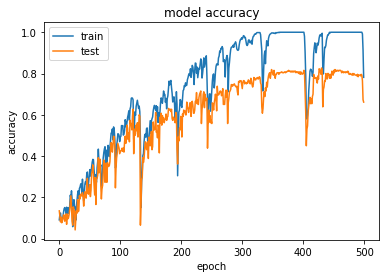

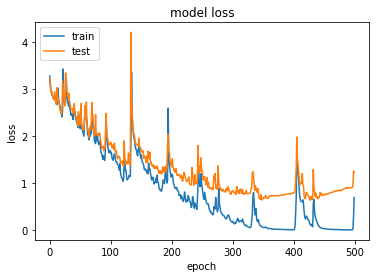

Accuracy: 66.15%


In [25]:
yrb_train_binary = to_categorical(yrb_train)
yrb_test_binary = to_categorical(yrb_test)


modelb = Sequential()
modelb.add(LSTM(100, input_shape=(300, 6)))
modelb.add(Dense(27,activation='sigmoid'))
adam = optimizers.Adam(lr=0.1, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
modelb.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

historyLb  = modelb.fit(Xrb_train, yrb_train_binary, validation_data=(Xrb_test,yrb_test_binary), epochs=500)
scoresLb = modelb.evaluate(Xrb_test, yrb_test_binary, verbose=0)
print(historyLb.history.keys())
# summarize history for accuracy
plt.plot(historyLb.history['acc'])
plt.plot(historyLb.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(historyLb.history['loss'])
plt.plot(historyLb.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


print("Accuracy: %.2f%%" % (scoresLb[1]*100))

In [32]:
predictionsLSTMb = modelb.predict(Xrb_test)
target_names = ['Swipe Left', 'Swipe Right', 'Wave', 'Clap', 'Throw', 'Arm Cross', 'Basketball Shoot', 
                'Draw X', 'Draw Circle (CW)', 'Draw Circle (CCW)', 'Draw Triangle', 'Bowling', 'Boxing', 
                'Baseball Swing', 'Tennis Swing', 'Arm Curl', 'Tennis Serve', 'Push', 'Knock', 'Catch',
                'Pickup and Throw', 'Jog', 'Walk', 'Sit to Stand', 'Stand to Sit', 'Lunge', 'Squat']
print(classification_report(yrb_test,  predictionsLSTMb.argmax(axis=1), target_names=target_names))

                   precision    recall  f1-score   support

       Swipe Left       0.88      0.88      0.88         8
      Swipe Right       0.91      0.91      0.91        11
             Wave       0.88      0.58      0.70        12
             Clap       1.00      0.50      0.67        12
            Throw       0.50      0.50      0.50         6
        Arm Cross       0.71      0.62      0.67         8
 Basketball Shoot       0.54      0.78      0.64         9
           Draw X       1.00      0.50      0.67        12
 Draw Circle (CW)       0.45      0.62      0.53         8
Draw Circle (CCW)       0.55      0.60      0.57        10
    Draw Triangle       0.38      0.75      0.50         8
          Bowling       1.00      0.78      0.88         9
           Boxing       0.57      0.50      0.53         8
   Baseball Swing       0.50      0.27      0.35        11
     Tennis Swing       0.33      0.20      0.25         5
         Arm Curl       0.93      1.00      0.96       

Confusion matrix


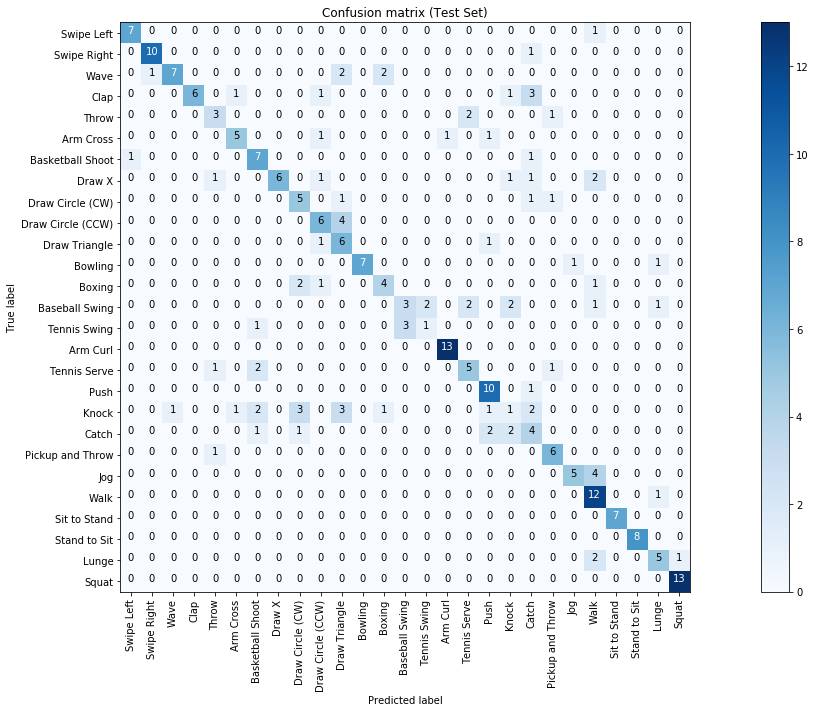

In [33]:
cnf_matrix = confusion_matrix(yrb_test, predictionsLSTMb.argmax(axis=1))
np.set_printoptions(precision=2)
plt.figure(figsize=(20,10))
plot_confusion_matrix(cnf_matrix, classes=target_names,
                      title='Confusion matrix (Test Set)')

### GRU

Train on 604 samples, validate on 260 samples
Epoch 1/500
604/604 [==============================] - 15s 26ms/step - loss: 3.2612 - acc: 0.1275 - val_loss: 3.2177 - val_acc: 0.1808
Epoch 2/500
604/604 [==============================] - 15s 24ms/step - loss: 3.1478 - acc: 0.1705 - val_loss: 3.0389 - val_acc: 0.0885
Epoch 3/500
604/604 [==============================] - 15s 24ms/step - loss: 2.9525 - acc: 0.0960 - val_loss: 2.9133 - val_acc: 0.0615
Epoch 4/500
604/604 [==============================] - 14s 24ms/step - loss: 2.8545 - acc: 0.0844 - val_loss: 2.8604 - val_acc: 0.0500
Epoch 5/500
604/604 [==============================] - 15s 24ms/step - loss: 2.8157 - acc: 0.0795 - val_loss: 2.8512 - val_acc: 0.0500
Epoch 6/500
604/604 [==============================] - 14s 24ms/step - loss: 2.7896 - acc: 0.1010 - val_loss: 2.8225 - val_acc: 0.0962
Epoch 7/500
604/604 [==============================] - 15s 24ms/step - loss: 2.7676 - acc: 0.1507 - val_loss: 2.8049 - val_acc: 0.1615
Epoch 8/5

Epoch 61/500
604/604 [==============================] - 12s 20ms/step - loss: 1.2313 - acc: 0.5646 - val_loss: 1.4829 - val_acc: 0.5115
Epoch 62/500
604/604 [==============================] - 12s 20ms/step - loss: 1.1110 - acc: 0.6192 - val_loss: 1.4506 - val_acc: 0.5538
Epoch 63/500
604/604 [==============================] - 12s 20ms/step - loss: 1.0569 - acc: 0.6440 - val_loss: 1.3901 - val_acc: 0.5269
Epoch 64/500
604/604 [==============================] - 12s 20ms/step - loss: 1.0953 - acc: 0.6026 - val_loss: 1.4119 - val_acc: 0.5269
Epoch 65/500
604/604 [==============================] - 12s 20ms/step - loss: 0.9965 - acc: 0.6722 - val_loss: 1.3332 - val_acc: 0.5577
Epoch 66/500
604/604 [==============================] - 12s 20ms/step - loss: 0.9376 - acc: 0.6755 - val_loss: 1.3863 - val_acc: 0.5423
Epoch 67/500
604/604 [==============================] - 12s 20ms/step - loss: 0.9099 - acc: 0.6954 - val_loss: 1.3577 - val_acc: 0.5577
Epoch 68/500
604/604 [==========================

604/604 [==============================] - 12s 20ms/step - loss: 0.2159 - acc: 0.9652 - val_loss: 1.2058 - val_acc: 0.6962
Epoch 122/500
604/604 [==============================] - 12s 20ms/step - loss: 0.3652 - acc: 0.9139 - val_loss: 1.4458 - val_acc: 0.5808
Epoch 123/500
604/604 [==============================] - 12s 20ms/step - loss: 0.5091 - acc: 0.8411 - val_loss: 1.3090 - val_acc: 0.6500
Epoch 124/500
604/604 [==============================] - 12s 20ms/step - loss: 0.5950 - acc: 0.8212 - val_loss: 1.3740 - val_acc: 0.6231
Epoch 125/500
604/604 [==============================] - 12s 20ms/step - loss: 0.4695 - acc: 0.8775 - val_loss: 1.1378 - val_acc: 0.6731
Epoch 126/500
604/604 [==============================] - 12s 20ms/step - loss: 0.3321 - acc: 0.9139 - val_loss: 1.1049 - val_acc: 0.7000
Epoch 127/500
604/604 [==============================] - 12s 20ms/step - loss: 0.2857 - acc: 0.9470 - val_loss: 1.1689 - val_acc: 0.7000
Epoch 128/500
604/604 [==============================] 

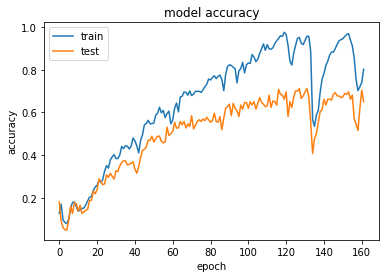

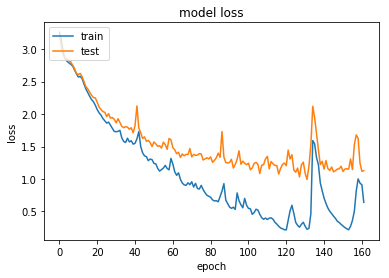

Accuracy: 65.00%


In [28]:
# GRU
model2 = Sequential()
model2.add(GRU(100, input_shape=(Xr_train.shape[1], Xr_train.shape[2])))
model2.add(Dense(yr_test_binary.shape[1], activation='sigmoid'))
model2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# Stop training when validation loss doesn't improve after 30 epochs
# Save the best model in terms of validation loss
gru_earlyStopping = EarlyStopping(monitor='val_loss', patience=30, verbose=0, mode='min')
gru_mcp_save = ModelCheckpoint('inertiagru.hdf5', save_best_only=True, monitor='val_loss', mode='min')
historyG  = model2.fit(Xr_train, yr_train_binary, validation_data=(Xr_test, yr_test_binary), epochs=500, batch_size=32, callbacks=[gru_earlyStopping, gru_mcp_save])
scoresG = model2.evaluate(Xr_test, yr_test_binary, verbose=0)

# summarize history for accuracy
plt.plot(historyG.history['acc'])
plt.plot(historyG.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(historyG.history['loss'])
plt.plot(historyG.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


print("Accuracy: %.2f%%" % (scoresG[1]*100))

In [29]:

predictionsGRU = model2.predict(Xr_test)
target_names = ['Swipe Left', 'Swipe Right', 'Wave', 'Clap', 'Throw', 'Arm Cross', 'Basketball Shoot', 
                'Draw X', 'Draw Circle (CW)', 'Draw Circle (CCW)', 'Draw Triangle', 'Bowling', 'Boxing', 
                'Baseball Swing', 'Tennis Swing', 'Arm Curl', 'Tennis Serve', 'Push', 'Knock', 'Catch',
                'Pickup and Throw', 'Jog', 'Walk', 'Sit to Stand', 'Stand to Sit', 'Lunge', 'Squat']
print(classification_report(yr_test,  predictionsGRU.argmax(axis=1), target_names=target_names))


                   precision    recall  f1-score   support

       Swipe Left       0.45      0.62      0.53         8
      Swipe Right       0.62      0.73      0.67        11
             Wave       0.69      0.75      0.72        12
             Clap       0.59      0.83      0.69        12
            Throw       0.20      0.17      0.18         6
        Arm Cross       1.00      0.88      0.93         8
 Basketball Shoot       0.75      0.67      0.71         9
           Draw X       1.00      0.25      0.40        12
 Draw Circle (CW)       0.47      0.88      0.61         8
Draw Circle (CCW)       0.67      0.40      0.50        10
    Draw Triangle       0.43      0.38      0.40         8
          Bowling       0.78      0.78      0.78         9
           Boxing       0.43      0.38      0.40         8
   Baseball Swing       0.78      0.64      0.70        11
     Tennis Swing       0.57      0.80      0.67         5
         Arm Curl       0.93      1.00      0.96       

Confusion matrix


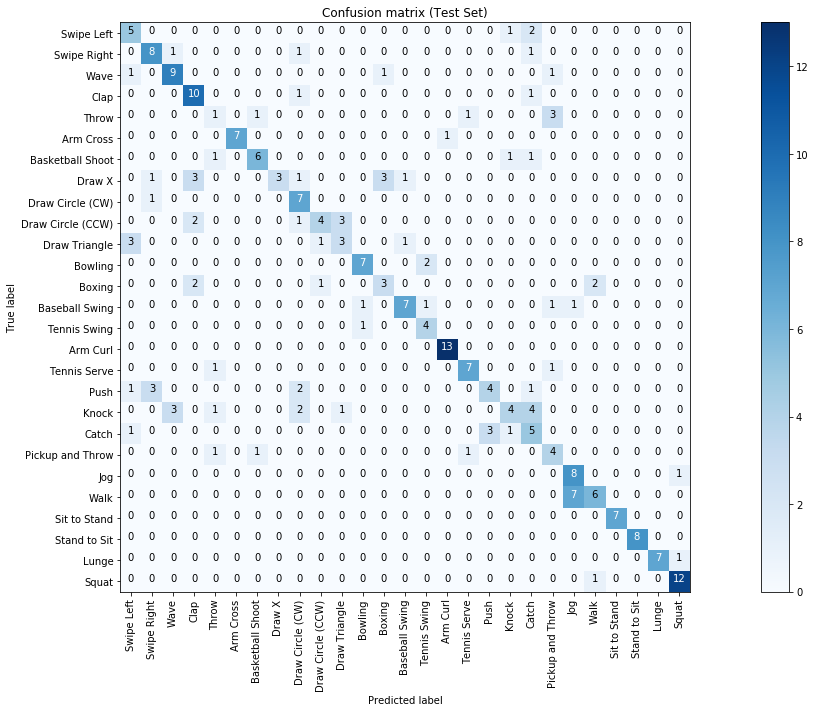

In [30]:
cnf_matrix = confusion_matrix(yr_test, predictionsGRU.argmax(axis=1))
np.set_printoptions(precision=2)
plt.figure(figsize=(20,10))
plot_confusion_matrix(cnf_matrix, classes=target_names,
                      title='Confusion matrix (Test Set)')

Train on 604 samples, validate on 260 samples
Epoch 1/500
604/604 [==============================] - 13s 21ms/step - loss: 3.2748 - acc: 0.1010 - val_loss: 3.2439 - val_acc: 0.1654
Epoch 2/500
604/604 [==============================] - 12s 20ms/step - loss: 3.1865 - acc: 0.2020 - val_loss: 3.0881 - val_acc: 0.1231
Epoch 3/500
604/604 [==============================] - 12s 20ms/step - loss: 3.0160 - acc: 0.1109 - val_loss: 3.2473 - val_acc: 0.0500
Epoch 4/500
604/604 [==============================] - 12s 20ms/step - loss: 3.0151 - acc: 0.1043 - val_loss: 2.9240 - val_acc: 0.0885
Epoch 5/500
604/604 [==============================] - 12s 20ms/step - loss: 2.8910 - acc: 0.1407 - val_loss: 2.8633 - val_acc: 0.1000
Epoch 6/500
604/604 [==============================] - 12s 20ms/step - loss: 2.8199 - acc: 0.1258 - val_loss: 2.8248 - val_acc: 0.1000
Epoch 7/500
604/604 [==============================] - 12s 20ms/step - loss: 2.7670 - acc: 0.1109 - val_loss: 2.7746 - val_acc: 0.0769
Epoch 8/5

Epoch 61/500
604/604 [==============================] - 12s 20ms/step - loss: 0.7130 - acc: 0.8278 - val_loss: 1.1150 - val_acc: 0.6962
Epoch 62/500
604/604 [==============================] - 12s 20ms/step - loss: 0.6831 - acc: 0.8129 - val_loss: 1.0503 - val_acc: 0.6808
Epoch 63/500
604/604 [==============================] - 12s 20ms/step - loss: 0.6543 - acc: 0.8377 - val_loss: 1.0333 - val_acc: 0.6731
Epoch 64/500
604/604 [==============================] - 12s 20ms/step - loss: 0.6068 - acc: 0.8411 - val_loss: 1.0681 - val_acc: 0.6769
Epoch 65/500
604/604 [==============================] - 12s 20ms/step - loss: 0.5977 - acc: 0.8411 - val_loss: 1.0134 - val_acc: 0.6962
Epoch 66/500
604/604 [==============================] - 12s 20ms/step - loss: 0.5875 - acc: 0.8344 - val_loss: 0.9939 - val_acc: 0.6923
Epoch 67/500
604/604 [==============================] - 12s 20ms/step - loss: 0.5256 - acc: 0.8709 - val_loss: 1.0423 - val_acc: 0.6923
Epoch 68/500
604/604 [==========================

604/604 [==============================] - 12s 20ms/step - loss: 0.0374 - acc: 1.0000 - val_loss: 0.7491 - val_acc: 0.7731
Epoch 122/500
604/604 [==============================] - 12s 20ms/step - loss: 0.0347 - acc: 1.0000 - val_loss: 0.7542 - val_acc: 0.7769
Epoch 123/500
604/604 [==============================] - 12s 20ms/step - loss: 0.0328 - acc: 1.0000 - val_loss: 0.7515 - val_acc: 0.7808
Epoch 124/500
604/604 [==============================] - 12s 20ms/step - loss: 0.0311 - acc: 1.0000 - val_loss: 0.7530 - val_acc: 0.7731
Epoch 125/500
604/604 [==============================] - 12s 20ms/step - loss: 0.0296 - acc: 1.0000 - val_loss: 0.7547 - val_acc: 0.7769
Epoch 126/500
604/604 [==============================] - 12s 20ms/step - loss: 0.0284 - acc: 1.0000 - val_loss: 0.7550 - val_acc: 0.7769
Epoch 127/500
604/604 [==============================] - 12s 20ms/step - loss: 0.0273 - acc: 1.0000 - val_loss: 0.7616 - val_acc: 0.7692
Epoch 128/500
604/604 [==============================] 

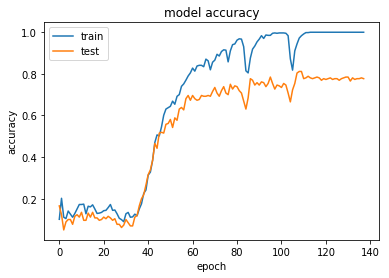

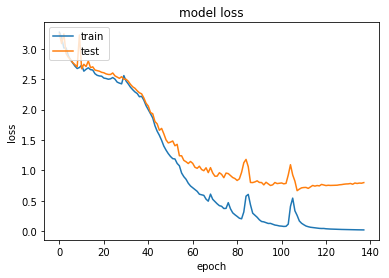

Accuracy: 77.69%


In [31]:

model2b = Sequential()
model2b.add(GRU(100, input_shape=(Xrb_train.shape[1], Xrb_train.shape[2])))
model2b.add(Dense(yrb_test_binary.shape[1], activation='sigmoid'))
model2b.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# Stop training when validation loss doesn't improve after 30 epochs
# Save the best model in terms of validation loss
grub_earlyStopping = EarlyStopping(monitor='val_loss', patience=30, verbose=0, mode='min')
grub_mcp_save = ModelCheckpoint('inertiagrub.hdf5', save_best_only=True, monitor='val_loss', mode='min')
historyGb  = model2b.fit(Xrb_train, yrb_train_binary, validation_data=(Xrb_test, yrb_test_binary), epochs=500, batch_size=32, callbacks=[grub_earlyStopping, grub_mcp_save])
scoresGb = model2b.evaluate(Xrb_test, yrb_test_binary, verbose=0)

# summarize history for accuracy
plt.plot(historyGb.history['acc'])
plt.plot(historyGb.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(historyGb.history['loss'])
plt.plot(historyGb.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


print("Accuracy: %.2f%%" % (scoresGb[1]*100))

In [36]:
predictionsGRUb = model2b.predict(Xrb_test)
target_names = ['Swipe Left', 'Swipe Right', 'Wave', 'Clap', 'Throw', 'Arm Cross', 'Basketball Shoot', 
                'Draw X', 'Draw Circle (CW)', 'Draw Circle (CCW)', 'Draw Triangle', 'Bowling', 'Boxing', 
                'Baseball Swing', 'Tennis Swing', 'Arm Curl', 'Tennis Serve', 'Push', 'Knock', 'Catch',
                'Pickup and Throw', 'Jog', 'Walk', 'Sit to Stand', 'Stand to Sit', 'Lunge', 'Squat']
print(classification_report(yrb_test,  predictionsGRUb.argmax(axis=1), target_names=target_names))


                   precision    recall  f1-score   support

       Swipe Left       0.50      0.75      0.60         8
      Swipe Right       1.00      1.00      1.00        11
             Wave       0.90      0.75      0.82        12
             Clap       0.86      1.00      0.92        12
            Throw       0.83      0.83      0.83         6
        Arm Cross       0.88      0.88      0.88         8
 Basketball Shoot       0.62      0.89      0.73         9
           Draw X       0.89      0.67      0.76        12
 Draw Circle (CW)       0.86      0.75      0.80         8
Draw Circle (CCW)       0.78      0.70      0.74        10
    Draw Triangle       0.62      0.62      0.62         8
          Bowling       1.00      0.89      0.94         9
           Boxing       0.36      0.62      0.45         8
   Baseball Swing       0.67      0.55      0.60        11
     Tennis Swing       0.50      0.60      0.55         5
         Arm Curl       0.93      1.00      0.96       

Confusion matrix


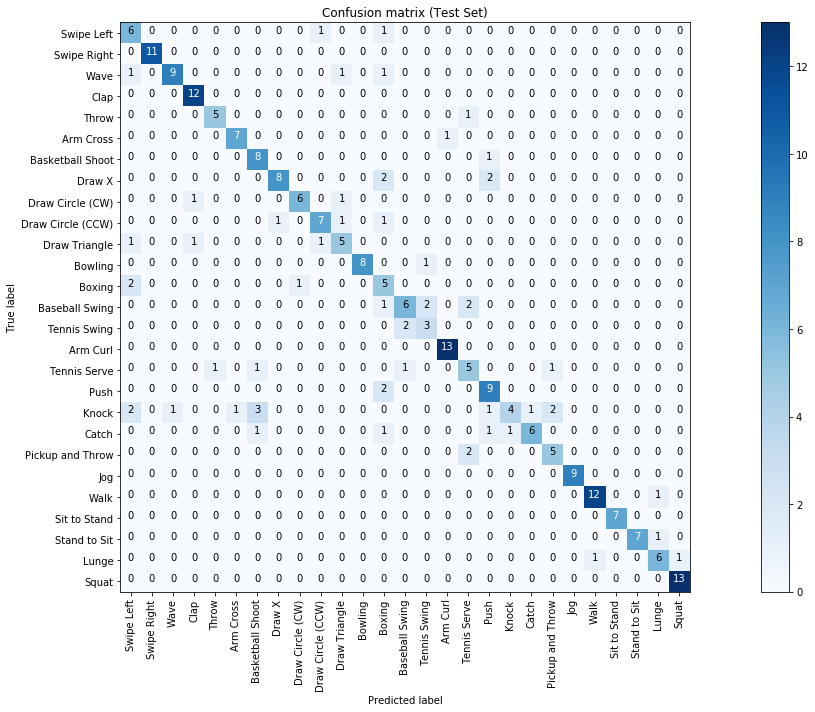

In [37]:
cnf_matrix = confusion_matrix(yrb_test, predictionsGRUb.argmax(axis=1))
np.set_printoptions(precision=2)
plt.figure(figsize=(20,10))
plot_confusion_matrix(cnf_matrix, classes=target_names,
                      title='Confusion matrix (Test Set)')

## Obtain peaks of Fast Fourier Transform

In [43]:
from scipy.signal import find_peaks

def generate_FFT_plots_np(sensor_data, activity, subject, trial):
    ylabel = 'Amplitude'
    axtitles = ['X-axis acceleration', 'Y-axis acceleration', 'Z-axis acceleration', 
                'X-axis angular vel','Y-axis angular vel','Z-axis angular vel']

    f, axarr = plt.subplots(nrows=2, ncols=3, figsize=(12,6))
    f.suptitle('Activity: %s, Subject: %s, Trial num: %s'%(activity +1,subject+1,trial+1), fontsize=20)

    for row_no in range(0,2):
        for col_no in range(0,3):
            comp_no = row_no * 3 + col_no      

            gtitle = axtitles[comp_no]
            xlabel = 'Frequency (Hz)'

            graph = axarr[row_no, col_no]
            graph.set_title(gtitle, fontsize=16)
            graph.set_xlabel(xlabel, fontsize=16)
            
            fft_y = np.fft.fft(sensor_data[activity][subject][trial][comp_no])
            fft_y = abs(fft_y)
            n = sensor_data[activity][subject][trial][comp_no].size
            timestep = 0.02
            freq = np.fft.fftfreq(n, d=timestep)
            
            graph.set_xlim(0,10)
            graph.plot(freq,fft_y)
            
            peaks, _ = find_peaks(fft_y, height=0)
            graph.plot(freq[peaks], fft_y[peaks], "x")
            
    plt.tight_layout()
    plt.subplots_adjust(top=0.90, hspace=0.6)
    plt.show()

## Plot FFT peaks for visuals (different subjects, same activity, same task)

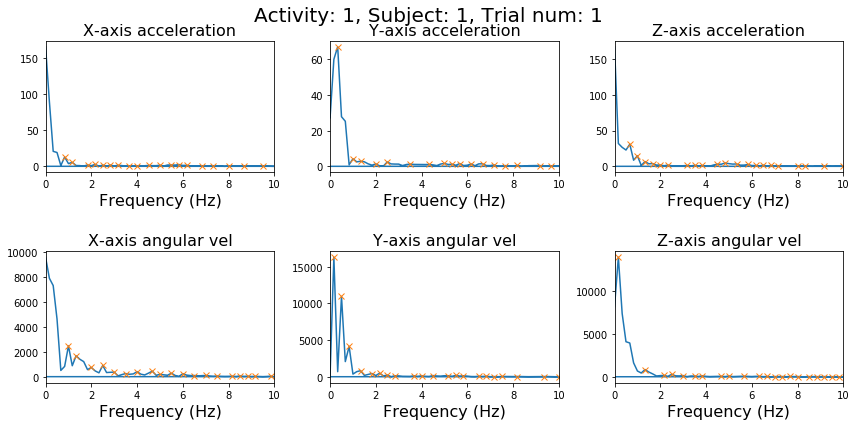

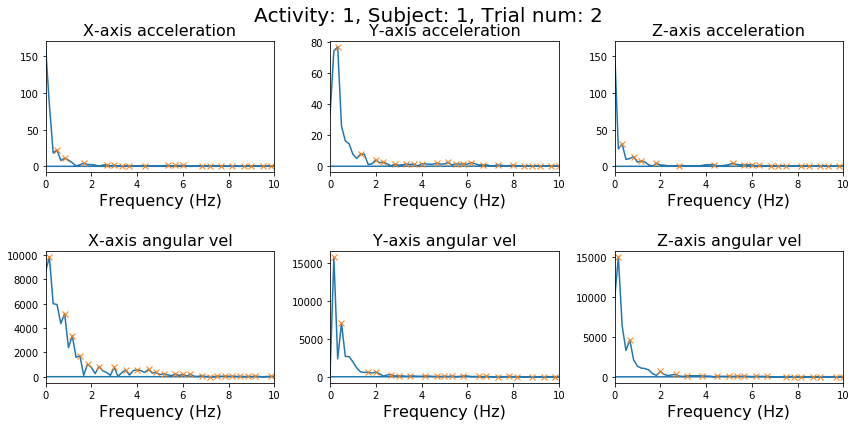

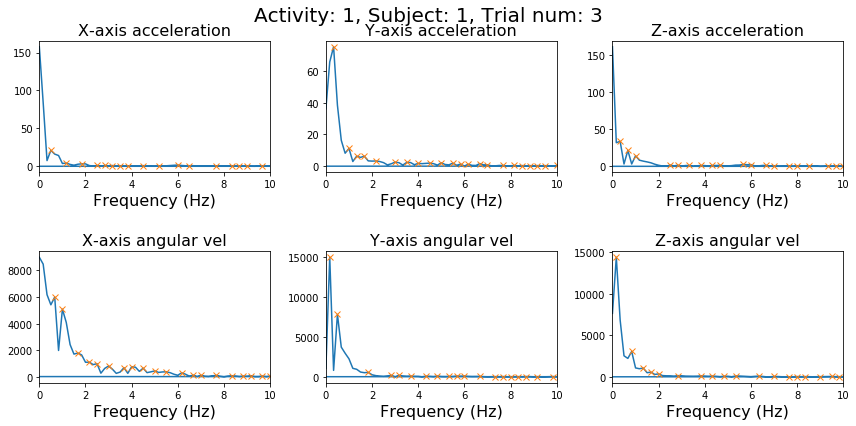

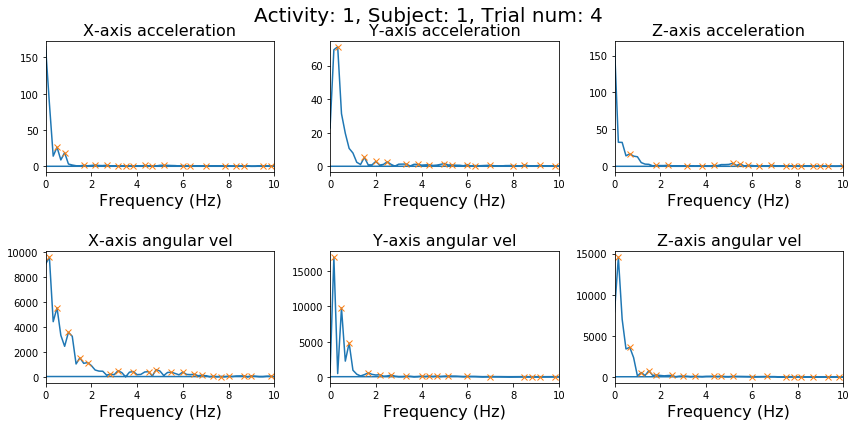

In [44]:
for trial in range(0,trial_end):
    generate_FFT_plots_np(activity_data, 0, 0, trial)

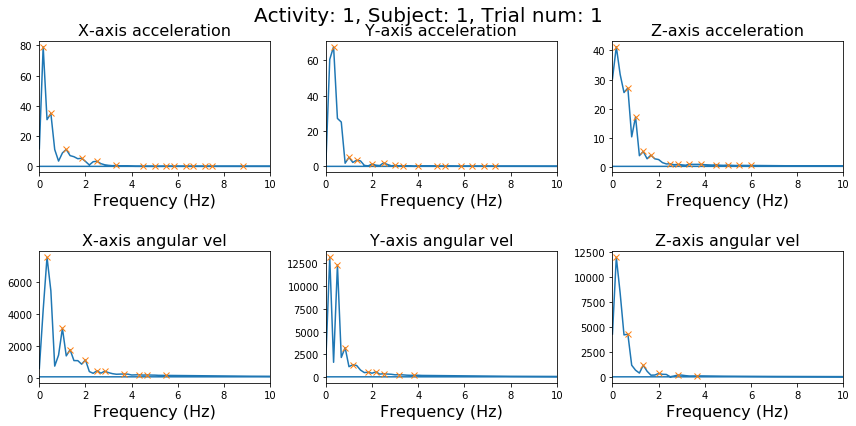

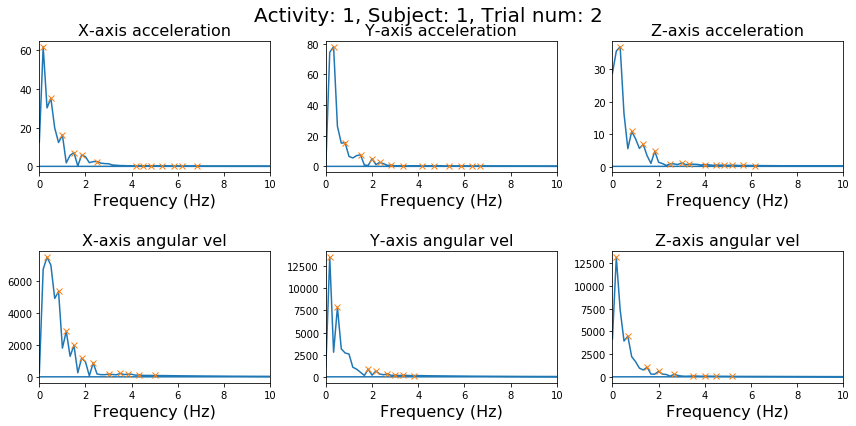

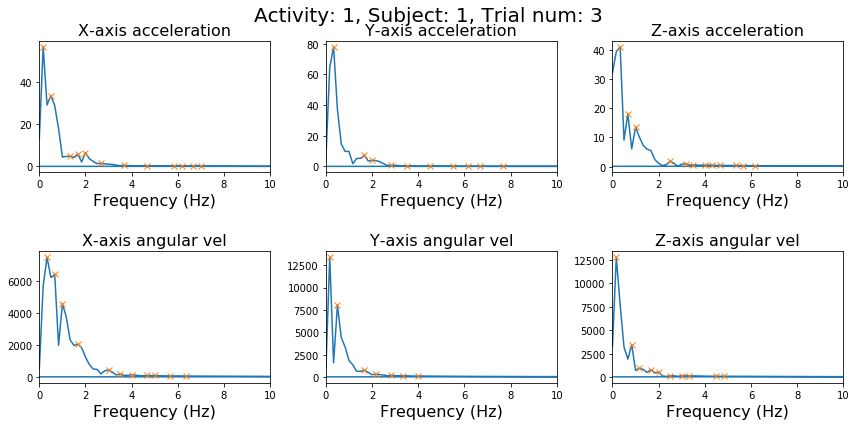

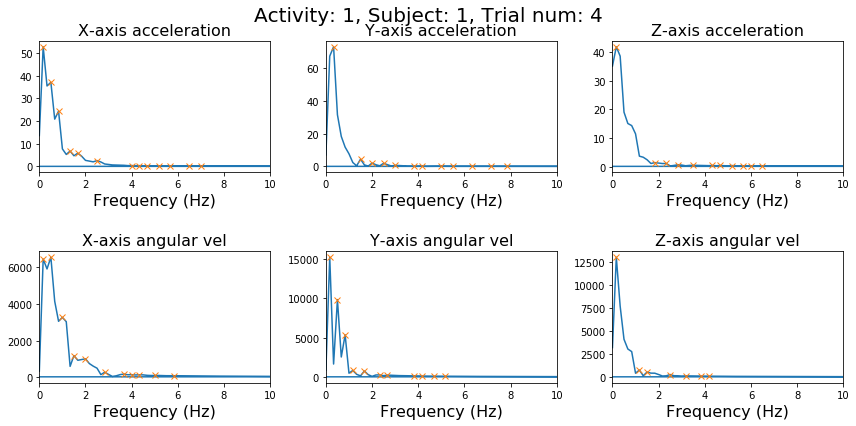

In [45]:
for trial in range(0,trial_end):
    generate_FFT_plots_np(bp_activity_data, 0, 0, trial)

## Extract peak features for machine learning

In [46]:
def get_first_n_fft_features(signal_plot, size):
    fft_y = np.fft.fft(signal_plot)
    fft_y = abs(fft_y)
    n = signal_plot.size
    timestep = 0.01
    freq = np.fft.fftfreq(n, d=timestep)
    fft_y =fft_y.tolist()
    freq = freq.tolist()

    return freq[:size] + fft_y[:size]


In [47]:
def extract_features_labels_fft(sensor_data):
    percentile = 5
    list_of_features = []
    list_of_labels = []
    T = 0.02
    f_s = 50
    denominator = 10
    for activity in range(0,activity_end):
        for person in range(0,subject_end):  
            for trial in range(0,trial_end):
                #iterate for each degree of freedom
                list_of_labels.append(activity)
                features = []
                for ax_dof in range(0,6):  
                    signal = sensor_data[activity][person][trial][ax_dof]

                    signal_min = np.nanpercentile(signal, percentile)
                    signal_max = np.nanpercentile(signal, 100-percentile)
                    #ijk = (100 - 2*percentile)/10
                    mph = signal_min + (signal_max - signal_min)/denominator

                    features += get_features(*get_psd_values(signal, T, signal.size, f_s), mph)
                    features += get_first_n_fft_features(signal, 5)
                    features += get_features(*get_autocorr_values(signal, T, signal.size, f_s), mph)

                    #print(activity, person, trial)
                list_of_features.append(features)                

    return np.array(list_of_features), np.array(list_of_labels)

In [50]:
X_features, Y_labels = extract_features_labels_fft(activity_data)
Xb_features, Yb_labels = extract_features_labels_fft(bp_activity_data)

In [51]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_features, Y_labels, test_size=0.3, random_state =1)
Xb_train, Xb_test, yb_train, yb_test = train_test_split(Xb_features, Yb_labels, test_size=0.3, random_state =1)

## Perform machine learning 

### Random Forest

In [52]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
target_names = ['Swipe Left', 'Swipe Right', 'Wave', 'Clap', 'Throw', 'Arm Cross', 'Basketball Shoot', 
                'Draw X', 'Draw Circle (CW)', 'Draw Circle (CCW)', 'Draw Triangle', 'Bowling', 'Boxing', 
                'Baseball Swing', 'Tennis Swing', 'Arm Curl', 'Tennis Serve', 'Push', 'Knock', 'Catch',
                'Pickup and Throw', 'Jog', 'Walk', 'Sit to Stand', 'Stand to Sit', 'Lunge', 'Squat']
clf = RandomForestClassifier(n_estimators=1000)
clf.fit(X_train, y_train)

print("Accuracy on training set is : {}".format(clf.score(X_train, y_train)))
print("Accuracy on test set is : {}".format(clf.score(X_test, y_test)))
Y_test_pred = clf.predict(X_test)

print(classification_report(y_test, Y_test_pred,target_names=target_names))

Accuracy on training set is : 1.0
Accuracy on test set is : 0.9346153846153846
                   precision    recall  f1-score   support

       Swipe Left       1.00      0.88      0.93         8
      Swipe Right       0.92      1.00      0.96        11
             Wave       1.00      1.00      1.00        12
             Clap       1.00      1.00      1.00        12
            Throw       1.00      0.83      0.91         6
        Arm Cross       0.67      1.00      0.80         8
 Basketball Shoot       0.82      1.00      0.90         9
           Draw X       1.00      1.00      1.00        12
 Draw Circle (CW)       0.80      1.00      0.89         8
Draw Circle (CCW)       1.00      0.90      0.95        10
    Draw Triangle       1.00      0.88      0.93         8
          Bowling       1.00      1.00      1.00         9
           Boxing       1.00      1.00      1.00         8
   Baseball Swing       1.00      0.91      0.95        11
     Tennis Swing       1.00      1

Confusion matrix


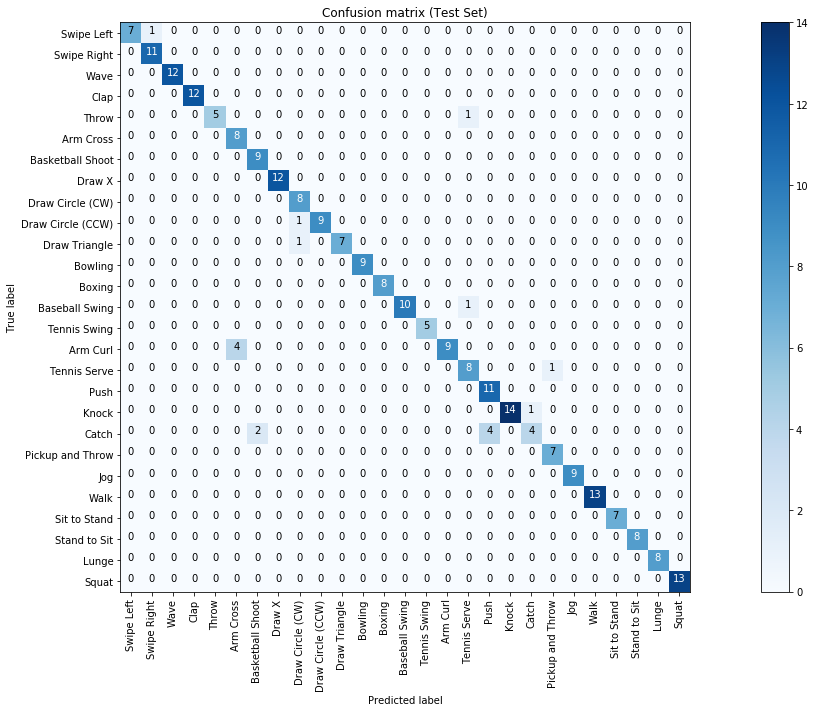

In [53]:
from utils import plot_confusion_matrix
from sklearn.metrics import confusion_matrix, classification_report

predictions = clf.predict(X_test)
cnf_matrix = confusion_matrix(y_test, predictions)
np.set_printoptions(precision=2)
plt.figure(figsize=(20,10))
plot_confusion_matrix(cnf_matrix, classes=target_names,
                      title='Confusion matrix (Test Set)')

In [54]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

clf2 = RandomForestClassifier(n_estimators=1000)
clf2.fit(Xb_train, yb_train)
Yb_test_pred = clf2.predict(Xb_test)

print("Accuracy on training set is : {}".format(clf2.score(Xb_train, yb_train)))
print("Accuracy on test set is : {}".format(clf2.score(Xb_test, yb_test)))
print(classification_report(yb_test, Yb_test_pred,target_names=target_names))



Accuracy on training set is : 1.0
Accuracy on test set is : 0.95
                   precision    recall  f1-score   support

       Swipe Left       1.00      1.00      1.00         8
      Swipe Right       1.00      0.82      0.90        11
             Wave       0.92      1.00      0.96        12
             Clap       1.00      1.00      1.00        12
            Throw       0.75      0.50      0.60         6
        Arm Cross       1.00      1.00      1.00         8
 Basketball Shoot       0.73      0.89      0.80         9
           Draw X       1.00      1.00      1.00        12
 Draw Circle (CW)       0.73      1.00      0.84         8
Draw Circle (CCW)       1.00      0.90      0.95        10
    Draw Triangle       1.00      0.88      0.93         8
          Bowling       1.00      1.00      1.00         9
           Boxing       1.00      1.00      1.00         8
   Baseball Swing       1.00      0.91      0.95        11
     Tennis Swing       1.00      1.00      1.00 

Confusion matrix


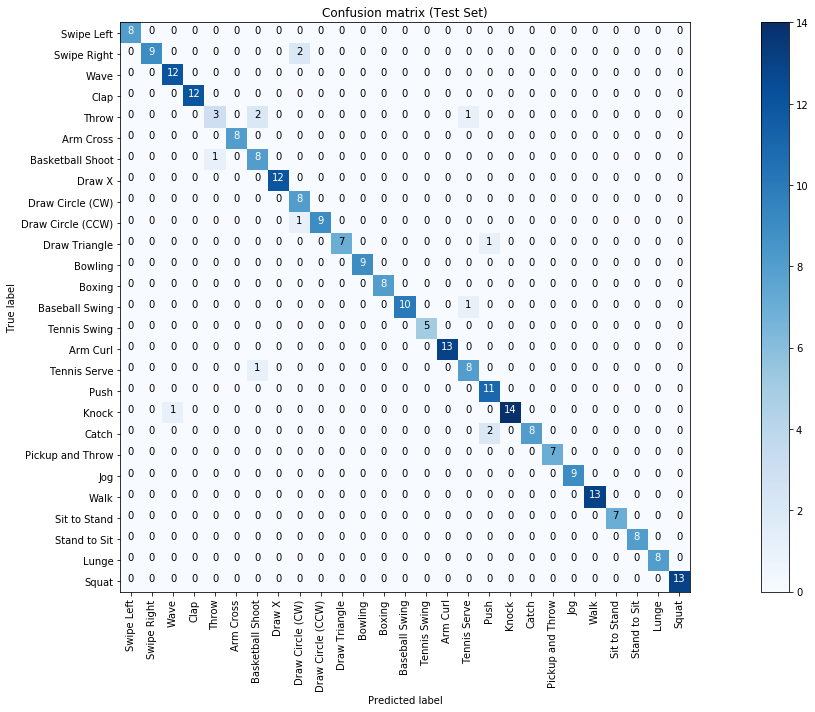

In [55]:
bfpredictions = clf2.predict(Xb_test)
cnf_matrix = confusion_matrix(yb_test, bfpredictions)
np.set_printoptions(precision=2)
plt.figure(figsize=(20,10))
plot_confusion_matrix(cnf_matrix, classes=target_names,
                      title='Confusion matrix (Test Set)')

In [56]:
def extract_features_labels_fft_only(sensor_data):
    percentile = 5
    list_of_features = []
    list_of_labels = []
    T = 0.02
    f_s = 50
    denominator = 10
    for activity in range(0,activity_end):
        for person in range(0,subject_end):  
            for trial in range(0,trial_end):
                #iterate for each degree of freedom
                list_of_labels.append(activity)
                features = []
                for ax_dof in range(0,6):  
                    signal = sensor_data[activity][person][trial][ax_dof]

                    signal_min = np.nanpercentile(signal, percentile)
                    signal_max = np.nanpercentile(signal, 100-percentile)
                    #ijk = (100 - 2*percentile)/10
                    mph = signal_min + (signal_max - signal_min)/denominator

                    features += get_first_n_fft_features(signal, 5)

                    #print(activity, person, trial)
                list_of_features.append(features)                

    return np.array(list_of_features), np.array(list_of_labels)

In [59]:
Xfft_features, Yfft_labels = extract_features_labels_fft_only(activity_data)
Xfftb_features, Yfftb_labels = extract_features_labels_fft_only(bp_activity_data)

In [60]:
Xf_train, Xf_test, yf_train, yf_test = train_test_split(Xfft_features, Yfft_labels, test_size=0.3, random_state =1)

In [66]:
clf3 = RandomForestClassifier(n_estimators=1000)
clf3.fit(Xf_train, yf_train)

print("Accuracy on training set is : {}".format(clf3.score(Xf_train, yf_train)))
print("Accuracy on test set is : {}".format(clf3.score(Xf_test, yf_test)))
Yf_test_pred = clf3.predict(Xf_test)

print(classification_report(yf_test, Yf_test_pred,target_names=target_names))

Accuracy on training set is : 1.0
Accuracy on test set is : 0.9384615384615385
                   precision    recall  f1-score   support

       Swipe Left       1.00      0.88      0.93         8
      Swipe Right       0.85      1.00      0.92        11
             Wave       0.91      0.83      0.87        12
             Clap       0.92      1.00      0.96        12
            Throw       1.00      1.00      1.00         6
        Arm Cross       0.88      0.88      0.88         8
 Basketball Shoot       1.00      1.00      1.00         9
           Draw X       1.00      1.00      1.00        12
 Draw Circle (CW)       0.88      0.88      0.88         8
Draw Circle (CCW)       0.90      0.90      0.90        10
    Draw Triangle       1.00      0.75      0.86         8
          Bowling       1.00      1.00      1.00         9
           Boxing       0.88      0.88      0.88         8
   Baseball Swing       1.00      1.00      1.00        11
     Tennis Swing       1.00      1